In [1]:
# CELL 1: Imports
import numpy as np
import nibabel as nib
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.stats import linregress
from scipy.ndimage import center_of_mass, label, binary_dilation
from nilearn import plotting
import pandas as pd

print("✓ Imports loaded")

✓ Imports loaded


In [2]:
# CELL 2: Paths and Configuration
BASE_DIR = Path("/user_data/csimmon2/long_pt")
OUTPUT_DIR = BASE_DIR / "analyses" / "rsa_corrected"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

SUBJECTS = {
    'sub-004': {
        'code': 'UD', 
        'sessions': ['01', '02', '03', '05', '06'],
        'hemi': 'l'
    },
    'sub-021': {
        'code': 'TC', 
        'sessions': ['01', '02', '03'],
        'hemi': 'r'
    }
}

# Cope mapping (condition > scramble contrasts)
COPE_MAP = {
    'face': 10,
    'word': 12,
    'object': 3,
    'house': 11
}

print(f"Base directory: {BASE_DIR}")
print(f"Output directory: {OUTPUT_DIR}")
print(f"Subjects: {list(SUBJECTS.keys())}")

Base directory: /user_data/csimmon2/long_pt
Output directory: /user_data/csimmon2/long_pt/analyses/rsa_corrected
Subjects: ['sub-004', 'sub-021']


In [3]:
# Complete Golarai Extraction with Category-Specific Masks
from scipy.ndimage import label, center_of_mass

def extract_functional_rois_final(subject_id, threshold_z=2.3):
    """
    Extract functional cluster ROIs across all sessions
    Using category-specific anatomical masks
    """
    code = SUBJECTS[subject_id]['code']
    hemi = 'l' if subject_id == 'sub-004' else 'r'
    sessions = SUBJECTS[subject_id]['sessions']
    
    print(f"\n{'='*70}")
    print(f"{code} - Functional Clusters (category-specific masks, z>{threshold_z})")
    print(f"{'='*70}")
    
    all_results = {}
    
    for category, cope_num in [('face', 10), ('word', 12), ('object', 3), ('house', 11)]:
        print(f"\n{category.upper()}:")
        all_results[category] = {}
        
        # Load category-specific mask
        mask_file = BASE_DIR / subject_id / 'ses-01' / 'ROIs' / f'{hemi}_{category}_searchmask.nii.gz'
        if not mask_file.exists():
            print(f"  ⚠️  Mask not found")
            continue
        
        mask = nib.load(mask_file).get_fdata() > 0
        affine = nib.load(mask_file).affine
        
        for session in sessions:
            feat_dir = BASE_DIR / subject_id / f'ses-{session}' / 'derivatives' / 'fsl' / 'loc' / 'HighLevel.gfeat'
            zstat_file = 'zstat1.nii.gz' if session == '01' else 'zstat1_ses01.nii.gz'
            cope_file = feat_dir / f'cope{cope_num}.feat' / 'stats' / zstat_file
            
            if not cope_file.exists():
                continue
            
            zstat = nib.load(cope_file).get_fdata()
            suprathresh = (zstat > threshold_z) & mask
            
            if suprathresh.sum() < 50:  # Minimum cluster size
                print(f"  ses-{session}: <50 voxels (skipped)")
                continue
            
            # Largest cluster
            labeled, n = label(suprathresh)
            sizes = [(labeled == i).sum() for i in range(1, n+1)]
            largest_idx = np.argmax(sizes) + 1
            roi_mask = (labeled == largest_idx)
            
            # Metrics
            peak_idx = np.unravel_index(np.argmax(zstat * roi_mask), zstat.shape)
            peak_z = zstat[peak_idx]
            centroid = nib.affines.apply_affine(affine, center_of_mass(roi_mask))
            
            all_results[category][session] = {
                'n_voxels': sizes[largest_idx-1],
                'peak_z': peak_z,
                'centroid': centroid,
                'roi_mask': roi_mask
            }
            
            print(f"  ses-{session}: {sizes[largest_idx-1]:4d} voxels, peak z={peak_z:.2f}")
    
    return all_results


def extract_concentric_spheres_final(subject_id, functional_results, radii=[3, 6, 9]):
    """
    Create concentric spheres at ses-01 peaks
    Measure selectivity across sessions
    """
    code = SUBJECTS[subject_id]['code']
    hemi = 'l' if subject_id == 'sub-004' else 'r'
    sessions = SUBJECTS[subject_id]['sessions']
    
    # Load anatomy for coordinate system
    mask_file = BASE_DIR / subject_id / 'ses-01' / 'ROIs' / f'{hemi}_face_searchmask.nii.gz'
    ref_img = nib.load(mask_file)
    affine = ref_img.affine
    
    print(f"\n{'='*70}")
    print(f"{code} - Concentric Spheres (r={radii}mm)")
    print(f"{'='*70}")
    
    sphere_results = {}
    
    for category, cope_num in [('face', 10), ('word', 12), ('object', 3), ('house', 11)]:
        
        # Check if category exists in ses-01
        if category not in functional_results or '01' not in functional_results[category]:
            print(f"\n{category.upper()}: No ses-01 peak, skipping")
            continue
        
        peak = functional_results[category]['01']['centroid']
        print(f"\n{category.upper()}: Peak at {peak}")
        
        # Create sphere masks
        brain_shape = ref_img.shape
        grid_coords = np.array(np.meshgrid(
            np.arange(brain_shape[0]),
            np.arange(brain_shape[1]),
            np.arange(brain_shape[2]),
            indexing='ij'
        )).reshape(3, -1).T
        
        grid_world = nib.affines.apply_affine(affine, grid_coords)
        distances = np.linalg.norm(grid_world - peak, axis=1)
        
        sphere_masks = {}
        for r in radii:
            mask_3d = np.zeros(brain_shape, dtype=bool)
            within = grid_coords[distances <= r]
            for coord in within:
                mask_3d[coord[0], coord[1], coord[2]] = True
            sphere_masks[r] = mask_3d
            print(f"  {r}mm sphere: {np.sum(sphere_masks[r])} voxels")
        
        # Measure selectivity across sessions
        selectivity = {r: {} for r in radii}
        
        for session in sessions:
            feat_dir = BASE_DIR / subject_id / f'ses-{session}' / 'derivatives' / 'fsl' / 'loc' / 'HighLevel.gfeat'
            zstat_file = 'zstat1.nii.gz' if session == '01' else 'zstat1_ses01.nii.gz'
            cope_file = feat_dir / f'cope{cope_num}.feat' / 'stats' / zstat_file
            
            if not cope_file.exists():
                continue
            
            zstat = nib.load(cope_file).get_fdata()
            
            for r in radii:
                mean_z = zstat[sphere_masks[r]].mean()
                selectivity[r][session] = mean_z
        
        # Print trajectory
        print(f"  Selectivity trajectory:")
        for r in radii:
            if r in selectivity and len(selectivity[r]) > 0:
                vals = [selectivity[r][s] for s in sessions if s in selectivity[r]]
                print(f"    {r}mm: {' → '.join([f'{v:.2f}' for v in vals])}")
        
        sphere_results[category] = {
            'peak': peak,
            'selectivity': selectivity
        }
    
    return sphere_results


# EXTRACT BOTH APPROACHES
print("\n" + "="*70)
print("EXTRACTING FUNCTIONAL ROIs - FINAL VERSION")
print("="*70)

golarai_functional_final = {}
golarai_spheres_final = {}

for subj in ['sub-004', 'sub-021']:
    golarai_functional_final[subj] = extract_functional_rois_final(subj, threshold_z=2.3)
    golarai_spheres_final[subj] = extract_concentric_spheres_final(
        subj, golarai_functional_final[subj], radii=[3, 6, 9]
    )

print("\n✓ Final ROI extraction complete!")


EXTRACTING FUNCTIONAL ROIs - FINAL VERSION

UD - Functional Clusters (category-specific masks, z>2.3)

FACE:
  ses-01:  352 voxels, peak z=3.50
  ses-02: 2834 voxels, peak z=6.81
  ses-03: 4282 voxels, peak z=8.76
  ses-05: 3798 voxels, peak z=8.69
  ses-06: 4068 voxels, peak z=13.33

WORD:
  ses-01: <50 voxels (skipped)
  ses-02: 1037 voxels, peak z=5.59
  ses-03: 1891 voxels, peak z=6.24
  ses-05:  858 voxels, peak z=6.32
  ses-06:  510 voxels, peak z=6.97

OBJECT:
  ses-01: 3747 voxels, peak z=6.77
  ses-02: 6577 voxels, peak z=7.90
  ses-03: 8011 voxels, peak z=8.62
  ses-05: 10690 voxels, peak z=10.12
  ses-06: 7137 voxels, peak z=11.29

HOUSE:
  ses-01: 1379 voxels, peak z=5.25
  ses-02: 1998 voxels, peak z=9.42
  ses-03: 3109 voxels, peak z=11.75
  ses-05: 4933 voxels, peak z=12.23
  ses-06: 4691 voxels, peak z=12.64

UD - Concentric Spheres (r=[3, 6, 9]mm)

FACE: Peak at [-29.67897727 -34.36079545  -4.47159091]
  3mm sphere: 115 voxels
  6mm sphere: 913 voxels
  9mm sphere: 30

In [10]:
# Category-specific anatomical search regions
CATEGORY_PARCELS = {
    'face': ['fusiform'],
    'word': ['fusiform'],
    'object': ['lateraloccipital'],
    'house': ['parahippocampal', 'lingual', 'isthmuscingulate']
}

# Create category-specific masks
def create_category_specific_masks(subject_id, dilation_iterations=1):
    """
    Create separate anatomical search masks for each category
    More precise than merged VOTC
    """
    code = SUBJECTS[subject_id]['code']
    hemi = 'l' if subject_id == 'sub-004' else 'r'
    roi_dir = BASE_DIR / subject_id / 'ses-01' / 'ROIs'
    
    print(f"\n{'='*70}")
    print(f"{code} - Category-Specific Masks (1x dilation)")
    print(f"{'='*70}")
    
    from scipy.ndimage import binary_dilation
    
    category_masks = {}
    
    for category, parcel_list in CATEGORY_PARCELS.items():
        print(f"\n{category.upper()}:")
        
        combined = None
        ref_img = None
        
        for parcel in parcel_list:
            parcel_file = roi_dir / f'{hemi}_{parcel}_mask.nii.gz'
            
            if not parcel_file.exists():
                print(f"  ⚠️  Missing: {parcel}")
                continue
            
            img = nib.load(parcel_file)
            mask = img.get_fdata() > 0
            n_vox = np.sum(mask)
            print(f"  {parcel:20s}: {n_vox:6d} voxels")
            
            if combined is None:
                combined = mask
                ref_img = img
            else:
                combined = combined | mask
        
        if combined is None:
            print(f"  ❌ No parcels found")
            continue
        
        print(f"  Combined (before dilation): {np.sum(combined):6d} voxels")
        
        # Single dilation
        combined = binary_dilation(combined, iterations=dilation_iterations)
        print(f"  After 1x dilation:          {np.sum(combined):6d} voxels")
        
        # Save
        output_file = roi_dir / f'{hemi}_{category}_searchmask.nii.gz'
        mask_img = nib.Nifti1Image(combined.astype(np.float32), ref_img.affine)
        nib.save(mask_img, output_file)
        
        category_masks[category] = output_file
        print(f"  ✓ Saved: {output_file.name}")
    
    return category_masks

# Create for both subjects
category_masks = {}
for subj in ['sub-004', 'sub-021']:
    category_masks[subj] = create_category_specific_masks(subj, dilation_iterations=1)

print("\n" + "="*70)
print("CATEGORY-SPECIFIC MASKS CREATED")
print("="*70)


UD - Category-Specific Masks (1x dilation)

FACE:
  fusiform            :  12134 voxels
  Combined (before dilation):  12134 voxels
  After 1x dilation:           19331 voxels
  ✓ Saved: l_face_searchmask.nii.gz

WORD:
  fusiform            :  12134 voxels
  Combined (before dilation):  12134 voxels
  After 1x dilation:           19331 voxels
  ✓ Saved: l_word_searchmask.nii.gz

OBJECT:
  lateraloccipital    :  15770 voxels
  Combined (before dilation):  15770 voxels
  After 1x dilation:           25843 voxels
  ✓ Saved: l_object_searchmask.nii.gz

HOUSE:
  parahippocampal     :   1847 voxels
  lingual             :   9576 voxels
  isthmuscingulate    :   3317 voxels
  Combined (before dilation):  14740 voxels
  After 1x dilation:           24507 voxels
  ✓ Saved: l_house_searchmask.nii.gz

TC - Category-Specific Masks (1x dilation)

FACE:
  fusiform            :   8484 voxels
  Combined (before dilation):   8484 voxels
  After 1x dilation:           13736 voxels
  ✓ Saved: r_face_sea

In [11]:
# Test coverage with new category-specific masks
def test_final_category_coverage(subject_id, threshold_z=2.3):
    """Test coverage with updated house mask (PPA + lingual + isthmus)"""
    code = SUBJECTS[subject_id]['code']
    
    print(f"\n{code} - Final Category-Specific Coverage (z>{threshold_z}):")
    print(f"{'Category':<10} {'Mask Size':>12} {'Largest Cluster':>16} {'Status'}")
    print("-"*70)
    
    for cat, cope in [('face', 10), ('word', 12), ('object', 3), ('house', 11)]:
        if cat not in category_masks[subject_id]:
            continue
        
        mask_file = category_masks[subject_id][cat]
        mask = nib.load(mask_file).get_fdata() > 0
        
        cope_file = BASE_DIR / subject_id / 'ses-01' / 'derivatives' / 'fsl' / 'loc' / \
                    'HighLevel.gfeat' / f'cope{cope}.feat' / 'stats' / 'zstat1.nii.gz'
        zstat = nib.load(cope_file).get_fdata()
        
        in_mask = (zstat > threshold_z) & mask
        
        from scipy.ndimage import label
        labeled, n = label(in_mask)
        largest = max([np.sum(labeled == i) for i in range(1, n+1)]) if n > 0 else 0
        peak_z = zstat[in_mask].max() if largest > 0 else 0
        
        if largest >= 300:
            status = "✓✓ EXCELLENT"
        elif largest >= 100:
            status = "✓  GOOD"
        elif largest >= 50:
            status = "⚠️  WEAK"
        else:
            status = "❌ TOO SMALL"
        
        print(f"{cat:<10} {np.sum(mask):>12} {largest:>10} vox   {status}  (peak z={peak_z:.1f})")

# Test both subjects
for subj in ['sub-004', 'sub-021']:
    test_final_category_coverage(subj, threshold_z=2.3)

print("\n" + "="*70)
print("Ready to extract functional ROIs with these masks!")
print("="*70)


UD - Final Category-Specific Coverage (z>2.3):
Category      Mask Size  Largest Cluster Status
----------------------------------------------------------------------
face              19331        352 vox   ✓✓ EXCELLENT  (peak z=3.5)
word              19331          3 vox   ❌ TOO SMALL  (peak z=2.6)
object            25843       3747 vox   ✓✓ EXCELLENT  (peak z=6.8)
house             24507       1379 vox   ✓✓ EXCELLENT  (peak z=5.3)

TC - Final Category-Specific Coverage (z>2.3):
Category      Mask Size  Largest Cluster Status
----------------------------------------------------------------------
face              13736       6689 vox   ✓✓ EXCELLENT  (peak z=16.1)
word              13736        709 vox   ✓✓ EXCELLENT  (peak z=7.3)
object            21271      12763 vox   ✓✓ EXCELLENT  (peak z=11.5)
house             17288       1107 vox   ✓✓ EXCELLENT  (peak z=5.4)

Ready to extract functional ROIs with these masks!


In [13]:
# CELL: Calculate peak drift (useful metric)
def calculate_peak_drift(functional_results):
    """Calculate total drift for each category"""
    print("\nPeak Movement Summary:")
    print(f"{'Subject':<8} {'Category':<8} {'Total Drift (mm)':<18} {'Sessions'}")
    print("-"*70)
    
    for subj in ['sub-004', 'sub-021']:
        code = SUBJECTS[subj]['code']
        for cat in ['face', 'word', 'object', 'house']:
            if cat not in functional_results[subj]:
                continue
            sessions = sorted(functional_results[subj][cat].keys())
            if len(sessions) < 2:
                continue
            
            first = functional_results[subj][cat][sessions[0]]['centroid']
            last = functional_results[subj][cat][sessions[-1]]['centroid']
            drift = np.linalg.norm(last - first)
            
            print(f"{code:<8} {cat:<8} {drift:>10.1f} mm        {', '.join(sessions)}")

calculate_peak_drift(golarai_functional_final)


Peak Movement Summary:
Subject  Category Total Drift (mm)   Sessions
----------------------------------------------------------------------
UD       face           11.1 mm        01, 02, 03, 05, 06
UD       word           24.4 mm        02, 03, 05, 06
UD       object          3.2 mm        01, 02, 03, 05, 06
UD       house          14.5 mm        01, 02, 03, 05, 06
TC       face            4.6 mm        01, 02, 03
TC       word           13.7 mm        01, 02, 03
TC       object          4.7 mm        01, 02, 03
TC       house           2.1 mm        01, 02, 03


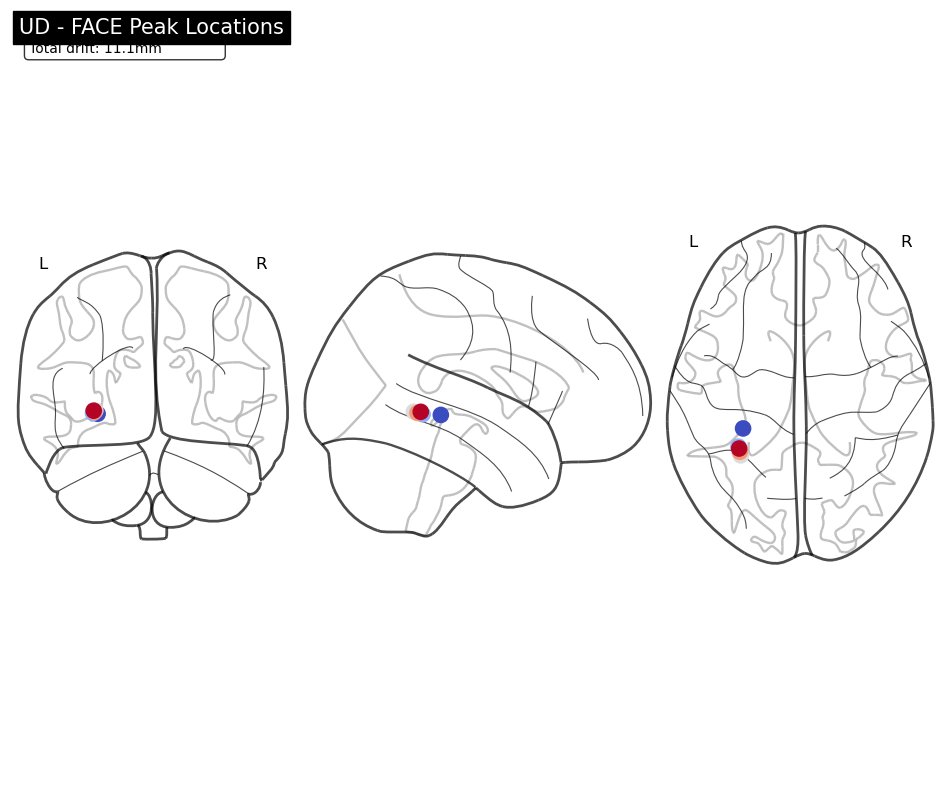

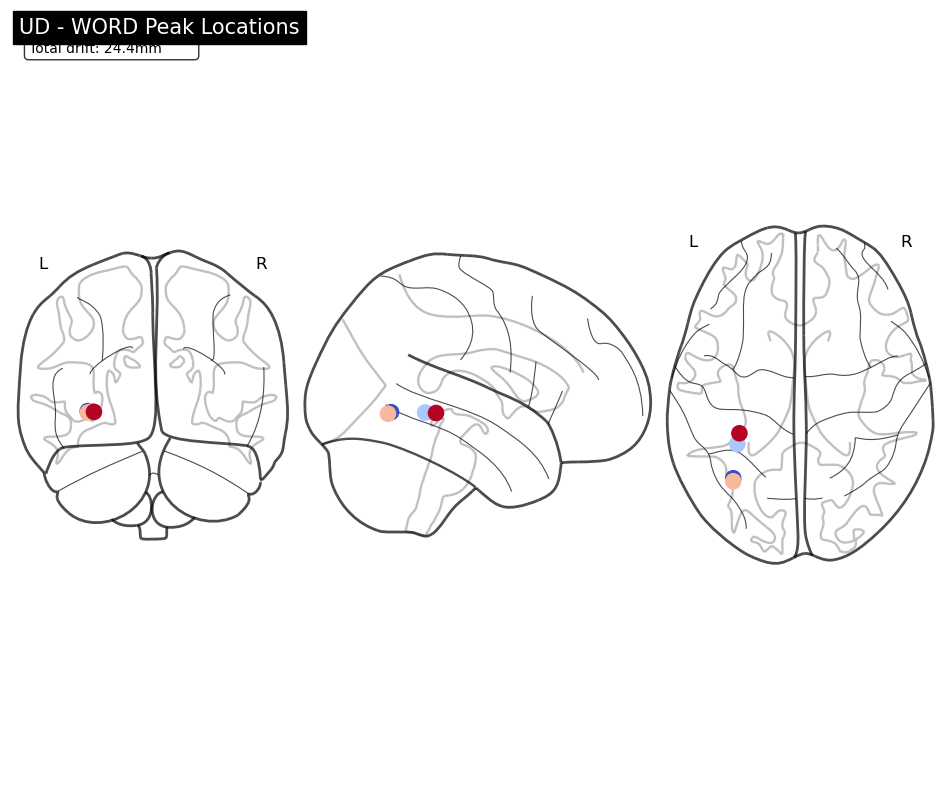

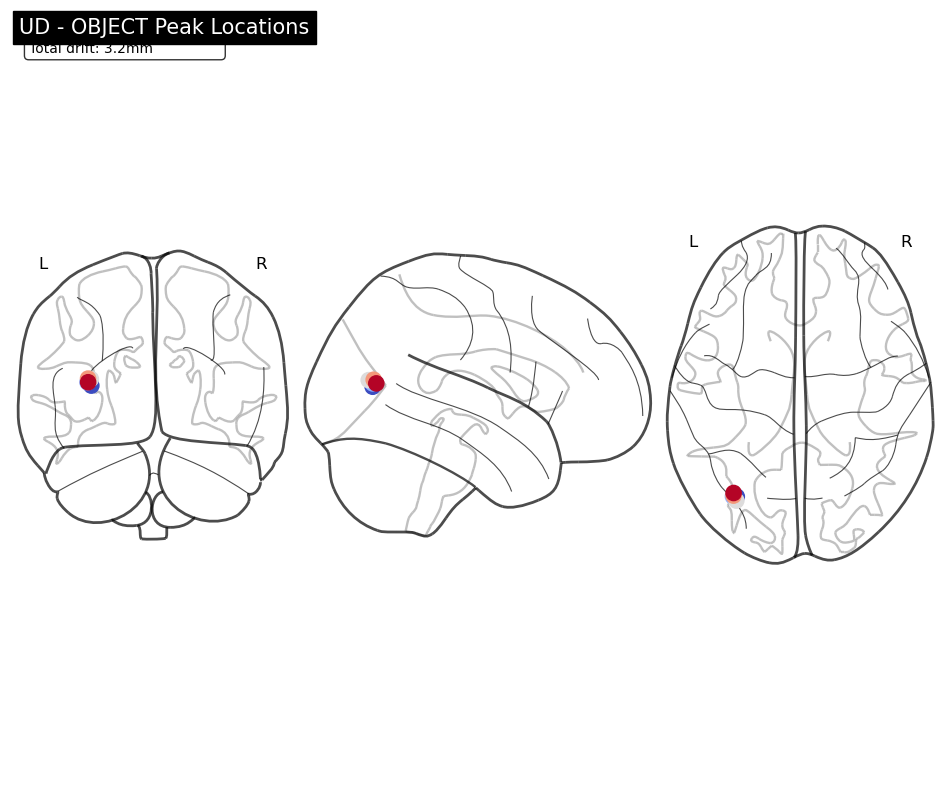

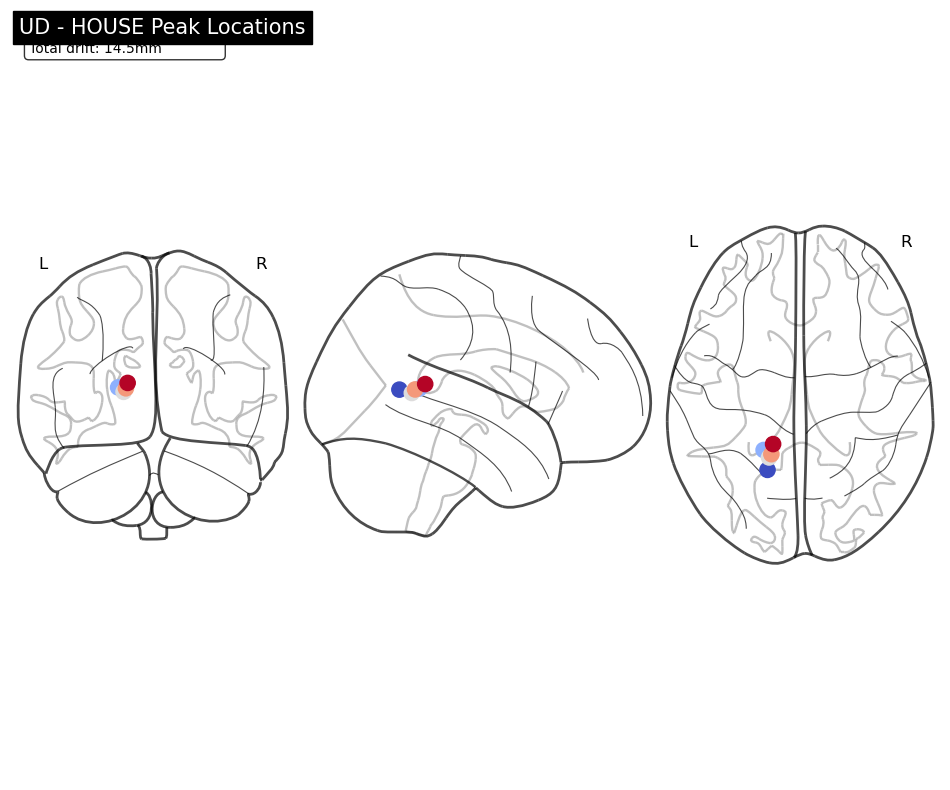

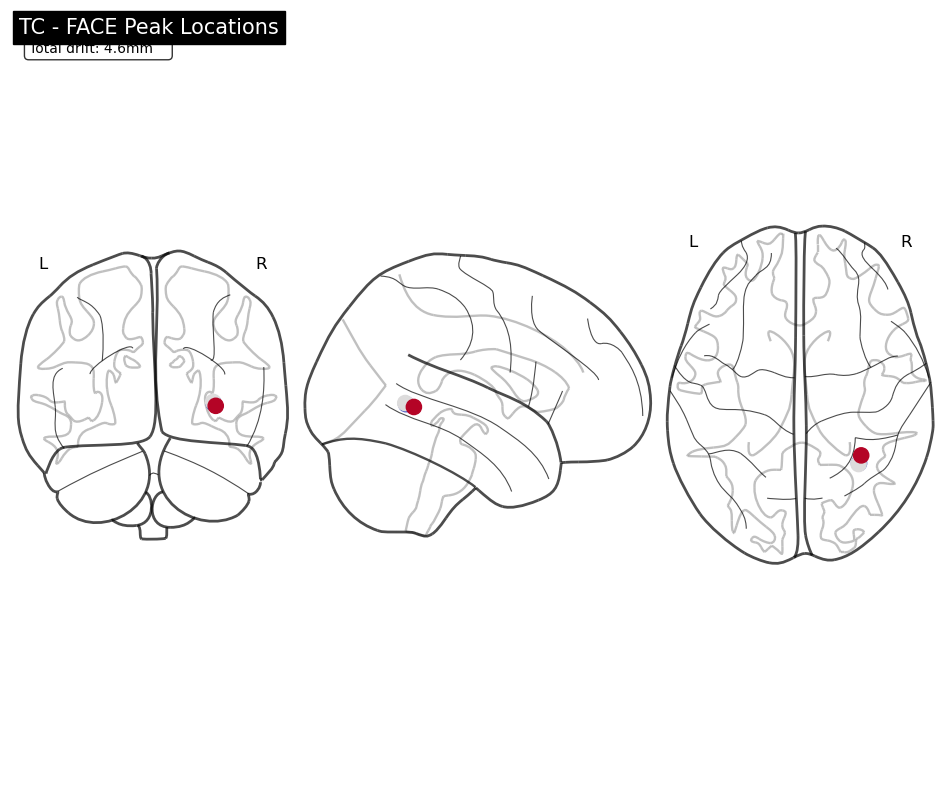

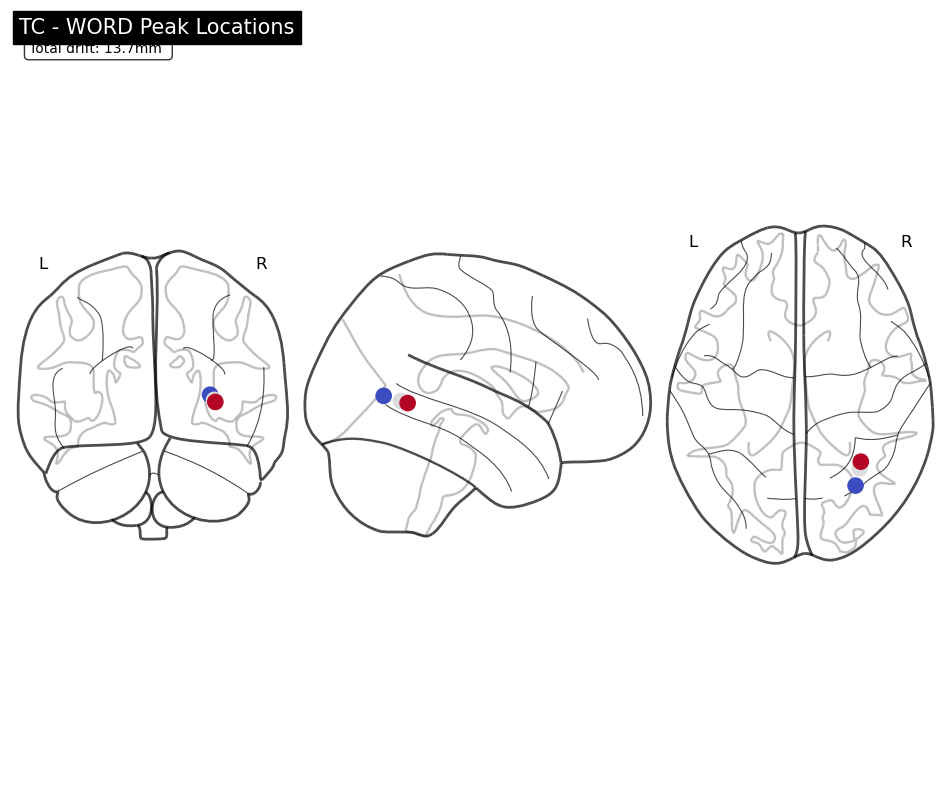

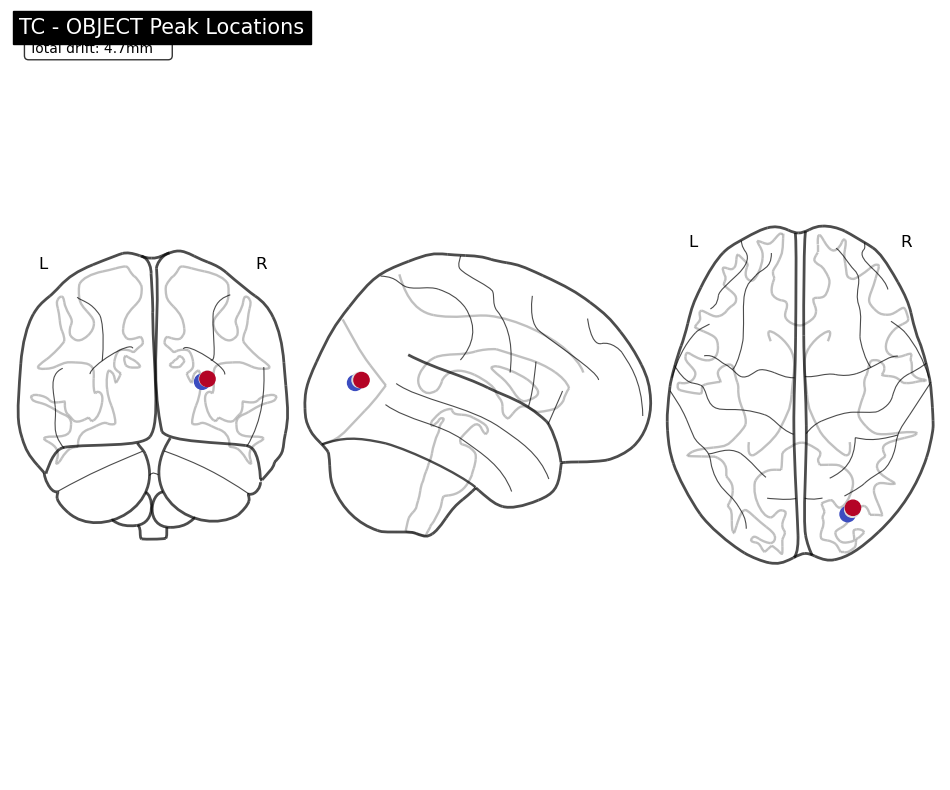

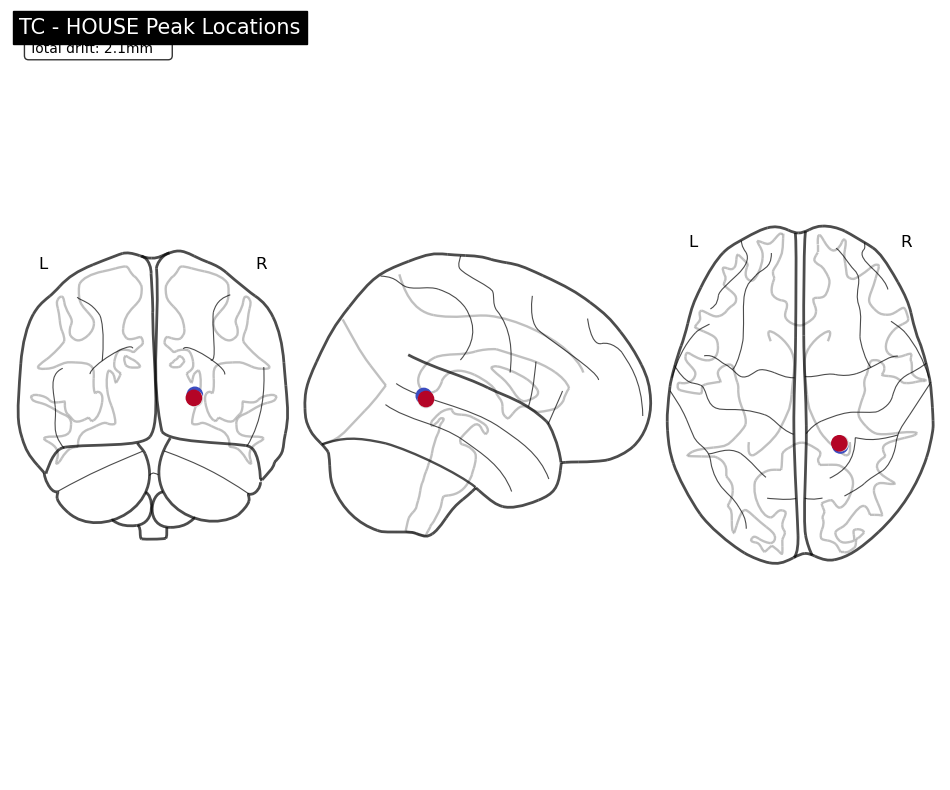

In [14]:
# CELL: Visualize functional trajectories on glass brains
from nilearn import plotting

def visualize_trajectories_final(subject_id, functional_results):
    """Show peak locations across sessions (no connecting lines)"""
    code = SUBJECTS[subject_id]['code']
    sessions = SUBJECTS[subject_id]['sessions']
    
    for category in ['face', 'word', 'object', 'house']:
        if category not in functional_results[subject_id]:
            continue
        
        # Collect centroids
        centroids = []
        valid_sessions = []
        for s in sessions:
            if s in functional_results[subject_id][category]:
                centroids.append(functional_results[subject_id][category][s]['centroid'])
                valid_sessions.append(s)
        
        if len(centroids) == 0:
            continue
        
        centroids = np.array(centroids)
        
        # NO LINES - just dots
        adjacency = np.zeros((len(centroids), len(centroids)))
        
        cmap = plt.cm.coolwarm
        colors = [cmap(i/(len(centroids)-1)) if len(centroids)>1 else cmap(0) 
                  for i in range(len(centroids))]
        
        fig, ax = plt.subplots(figsize=(12, 10))
        plotting.plot_connectome(adjacency, centroids, node_color=colors,
                                node_size=120, axes=ax, colorbar=False,
                                title=f'{code} - {category.upper()} Peak Locations')
        
        # Drift info
        total_drift = np.linalg.norm(centroids[-1] - centroids[0]) if len(centroids) > 1 else 0
        info = f"Sessions: {', '.join(valid_sessions)}\nTotal drift: {total_drift:.1f}mm"
        
        ax.text(0.02, 0.98, info, transform=ax.transAxes,
               fontsize=10, verticalalignment='top',
               bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        plt.savefig(OUTPUT_DIR / f'{code}_{category}_trajectory.png', dpi=300, bbox_inches='tight')
        plt.show()

# Visualize both subjects
for subj in ['sub-004', 'sub-021']:
    visualize_trajectories_final(subj, golarai_functional_final)

In [16]:
# Comprehensive parcel summary
def summarize_all_parcels():
    """Print dimensions and voxel counts for all parcels used"""
    
    print("\n" + "="*80)
    print("PARCEL SUMMARY: All Anatomical Masks")
    print("="*80)
    
    for subject_id in ['sub-004', 'sub-021']:
        code = SUBJECTS[subject_id]['code']
        hemi = 'l' if subject_id == 'sub-004' else 'r'
        roi_dir = BASE_DIR / subject_id / 'ses-01' / 'ROIs'
        
        print(f"\n{code} ({hemi.upper()}H - {'Left' if hemi=='l' else 'Right'} Hemisphere Preserved)")
        print("-"*80)
        
        # Individual DK parcels
        print("\nINDIVIDUAL DESIKAN-KILLIANY PARCELS:")
        parcels = ['fusiform', 'lateraloccipital', 'parahippocampal', 
                   'inferiortemporal', 'middletemporal', 'lingual', 'isthmuscingulate']
        
        for parcel in parcels:
            parcel_file = roi_dir / f'{hemi}_{parcel}_mask.nii.gz'
            if parcel_file.exists():
                img = nib.load(parcel_file)
                data = img.get_fdata() > 0
                dims = img.shape
                n_vox = np.sum(data)
                voxsize = img.header.get_zooms()[:3]
                volume_mm3 = n_vox * np.prod(voxsize)
                print(f"  {parcel:20s}: {n_vox:6d} voxels | "
                      f"dims: {dims[0]}×{dims[1]}×{dims[2]} | "
                      f"voxsize: {voxsize[0]:.1f}×{voxsize[1]:.1f}×{voxsize[2]:.1f}mm | "
                      f"vol: {volume_mm3/1000:.1f}cm³")
            else:
                print(f"  {parcel:20s}: NOT FOUND")
        
        # Category-specific search masks
        print(f"\nCATEGORY-SPECIFIC SEARCH MASKS (after 1x dilation):")
        
        for category in ['face', 'word', 'object', 'house']:
            mask_file = roi_dir / f'{hemi}_{category}_searchmask.nii.gz'
            if mask_file.exists():
                img = nib.load(mask_file)
                data = img.get_fdata() > 0
                dims = img.shape
                n_vox = np.sum(data)
                voxsize = img.header.get_zooms()[:3]
                volume_mm3 = n_vox * np.prod(voxsize)
                
                # Note special handling
                note = " (POSTERIOR FUSIFORM ONLY)" if category == 'word' and subject_id == 'sub-004' else ""
                
                print(f"  {category.upper():8s}{note:30s}: {n_vox:6d} voxels | "
                      f"dims: {dims[0]}×{dims[1]}×{dims[2]} | "
                      f"vol: {volume_mm3/1000:.1f}cm³")
            else:
                print(f"  {category.upper():8s}: NOT FOUND")
        
        # Composition
        print(f"\nCATEGORY MASK COMPOSITION:")
        print(f"  FACE:   fusiform")
        if subject_id == 'sub-004':
            print(f"  WORD:   posterior fusiform (y < median)")
        else:
            print(f"  WORD:   fusiform")
        print(f"  OBJECT: lateraloccipital")
        print(f"  HOUSE:  parahippocampal + lingual + isthmuscingulate")

summarize_all_parcels()


PARCEL SUMMARY: All Anatomical Masks

UD (LH - Left Hemisphere Preserved)
--------------------------------------------------------------------------------

INDIVIDUAL DESIKAN-KILLIANY PARCELS:
  fusiform            :  12134 voxels | dims: 176×256×256 | voxsize: 1.0×1.0×1.0mm | vol: 12.1cm³
  lateraloccipital    :  15770 voxels | dims: 176×256×256 | voxsize: 1.0×1.0×1.0mm | vol: 15.8cm³
  parahippocampal     :   1847 voxels | dims: 176×256×256 | voxsize: 1.0×1.0×1.0mm | vol: 1.8cm³
  inferiortemporal    :  14609 voxels | dims: 176×256×256 | voxsize: 1.0×1.0×1.0mm | vol: 14.6cm³
  middletemporal      :  15030 voxels | dims: 176×256×256 | voxsize: 1.0×1.0×1.0mm | vol: 15.0cm³
  lingual             :   9576 voxels | dims: 176×256×256 | voxsize: 1.0×1.0×1.0mm | vol: 9.6cm³
  isthmuscingulate    :   3317 voxels | dims: 176×256×256 | voxsize: 1.0×1.0×1.0mm | vol: 3.3cm³

CATEGORY-SPECIFIC SEARCH MASKS (after 1x dilation):
  FACE                                  :  19331 voxels | dims: 176×25

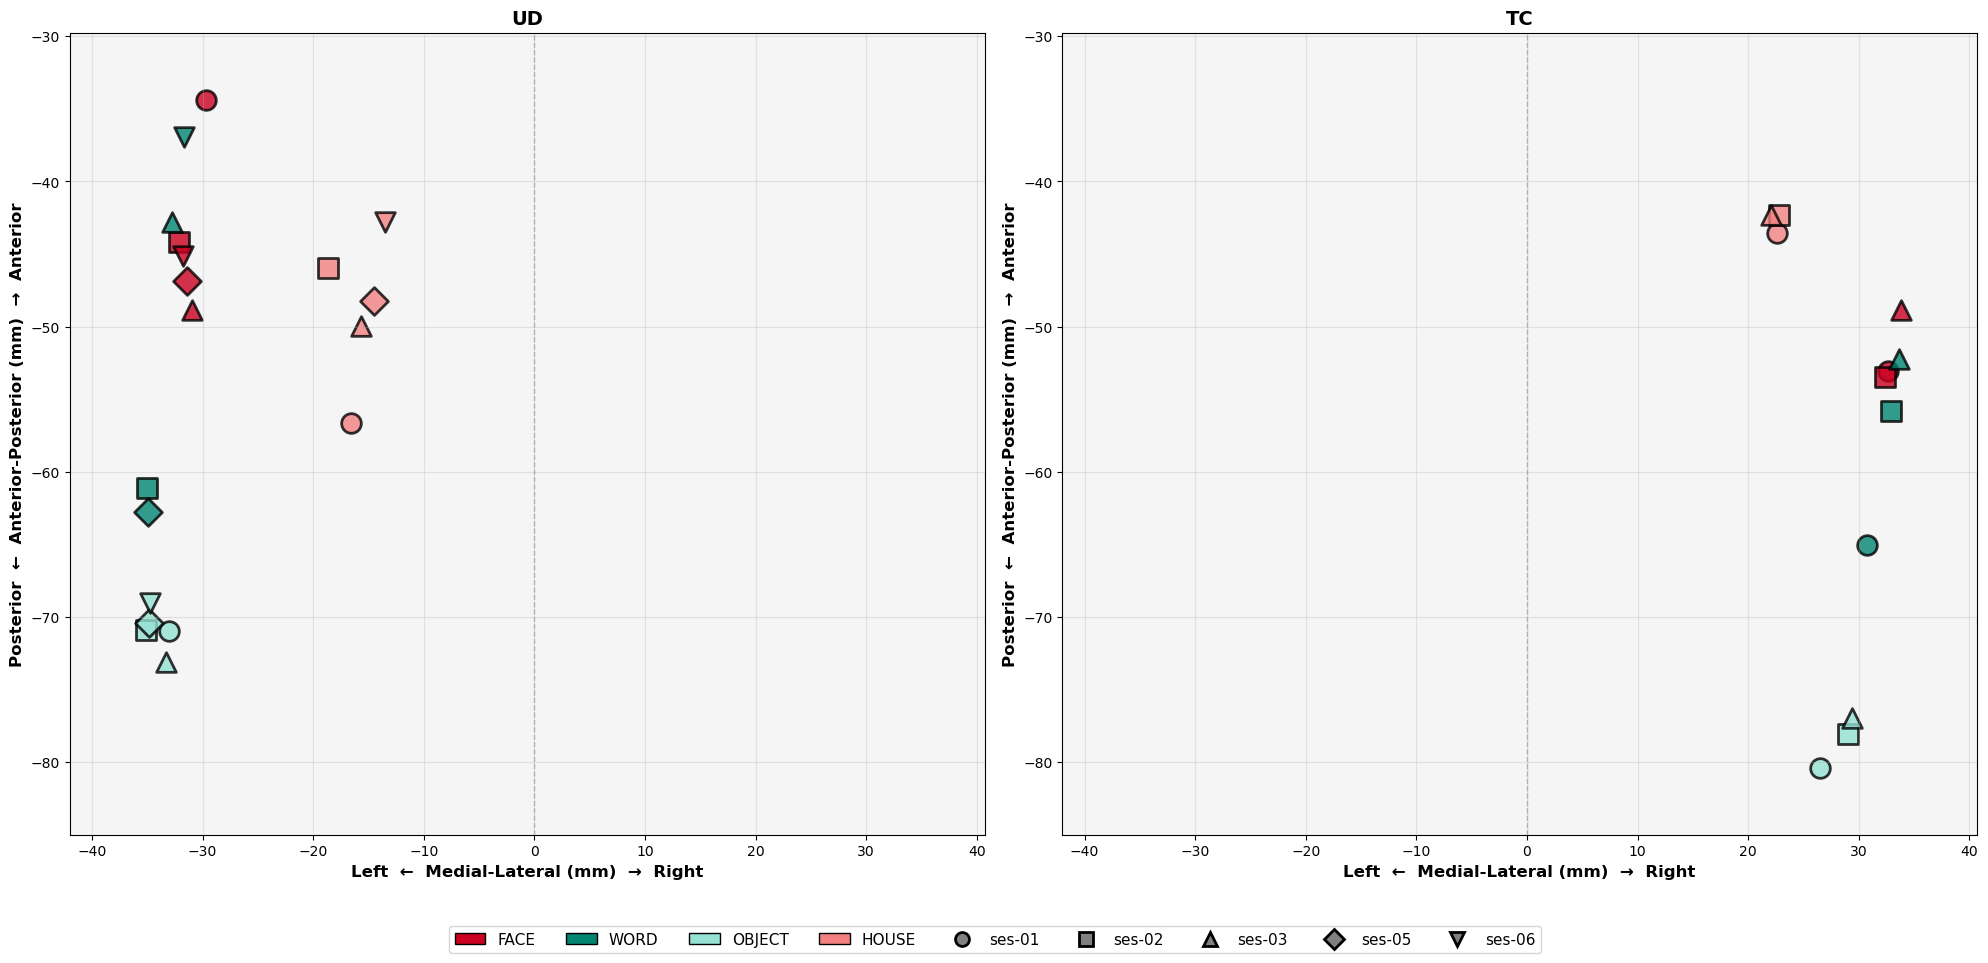

In [20]:
def plot_both_subjects_topography(functional_results):
    """Both subjects on same figure for comparison"""
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 9))
    
    colors = {
        'face': '#CA0020',
        'word': '#018571',
        'object': '#95E1D3',
        'house': '#F38181'
    }
    markers = {'01': 'o', '02': 's', '03': '^', '05': 'D', '06': 'v'}
    
    # Collect all x and y values to determine shared axis limits
    all_x, all_y = [], []
    
    for ax, subject_id in zip([ax1, ax2], ['sub-004', 'sub-021']):
        code = SUBJECTS[subject_id]['code']
        sessions = SUBJECTS[subject_id]['sessions']
        
        for category in ['face', 'word', 'object', 'house']:
            if category not in functional_results[subject_id]:
                continue
            
            for session in sessions:
                if session not in functional_results[subject_id][category]:
                    continue
                
                centroid = functional_results[subject_id][category][session]['centroid']
                x = centroid[0]
                y = centroid[1]
                
                all_x.append(x)
                all_y.append(y)
                
                ax.scatter(x, y, c=colors[category], marker=markers.get(session, 'o'),
                          s=200, edgecolors='black', linewidth=2, alpha=0.8)
        
        # Formatting
        ax.axvline(x=0, color='gray', linestyle='--', linewidth=1, alpha=0.5)
        ax.axhline(y=0, color='gray', linestyle='--', linewidth=1, alpha=0.5)
        ax.set_xlabel('Left  ←  Medial-Lateral (mm)  →  Right', fontsize=12, fontweight='bold')
        ax.set_ylabel('Posterior  ←  Anterior-Posterior (mm)  →  Anterior', fontsize=12, fontweight='bold')
        ax.set_title(f'{code}', fontsize=14, fontweight='bold')
        ax.grid(True, alpha=0.3)
        ax.set_facecolor('#F5F5F5')
    
    # Set shared axis limits with padding
    x_margin = (max(all_x) - min(all_x)) * 0.1
    y_margin = (max(all_y) - min(all_y)) * 0.1
    
    xlim = [min(all_x) - x_margin, max(all_x) + x_margin]
    ylim = [min(all_y) - y_margin, max(all_y) + y_margin]
    
    ax1.set_xlim(xlim)
    ax1.set_ylim(ylim)
    ax2.set_xlim(xlim)
    ax2.set_ylim(ylim)
    
    # Shared legend
    from matplotlib.patches import Patch
    from matplotlib.lines import Line2D
    
    category_legend = [Patch(facecolor=colors[cat], edgecolor='black', label=cat.upper()) 
                      for cat in ['face', 'word', 'object', 'house']]
    session_legend = [Line2D([0], [0], marker=markers.get(s, 'o'), color='w', 
                            markerfacecolor='gray', markersize=10, 
                            markeredgecolor='black', markeredgewidth=2, label=f'ses-{s}')
                     for s in ['01', '02', '03', '05', '06']]
    
    fig.legend(handles=category_legend + session_legend, 
              loc='center', bbox_to_anchor=(0.5, -0.05), 
              ncol=9, fontsize=11, frameon=True)
    
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / 'both_subjects_topography.png', dpi=300, bbox_inches='tight')
    plt.show()

plot_both_subjects_topography(golarai_functional_final)


UD - Functional Clusters (z>2.3)

FACE:
  ses-01:  352 voxels, peak z=3.50
  ses-02: 2834 voxels, peak z=6.81
  ses-03: 4282 voxels, peak z=8.76
  ses-05: 3798 voxels, peak z=8.69
  ses-06: 4068 voxels, peak z=13.33

WORD:
  ses-01: <50 voxels (skipped)
  ses-02: 1037 voxels, peak z=5.59
  ses-03: 1891 voxels, peak z=6.24
  ses-05:  858 voxels, peak z=6.32
  ses-06:  510 voxels, peak z=6.97

OBJECT:
  ses-01: 3747 voxels, peak z=6.77
  ses-02: 6577 voxels, peak z=7.90
  ses-03: 8011 voxels, peak z=8.62
  ses-05: 10690 voxels, peak z=10.12
  ses-06: 7137 voxels, peak z=11.29

HOUSE:
  ses-01: 1379 voxels, peak z=5.25
  ses-02: 1998 voxels, peak z=9.42
  ses-03: 3109 voxels, peak z=11.75
  ses-05: 4933 voxels, peak z=12.23
  ses-06: 4691 voxels, peak z=12.64

UD - Concentric Spheres (r=[3, 6, 9]mm)

FACE: Peak at [-29.67897727 -34.36079545  -4.47159091]
  3mm sphere: 115 voxels
  6mm sphere: 913 voxels
  9mm sphere: 3068 voxels
  Selectivity trajectory:
    3mm: 2.44 → 5.23 → 5.66 → 5.2

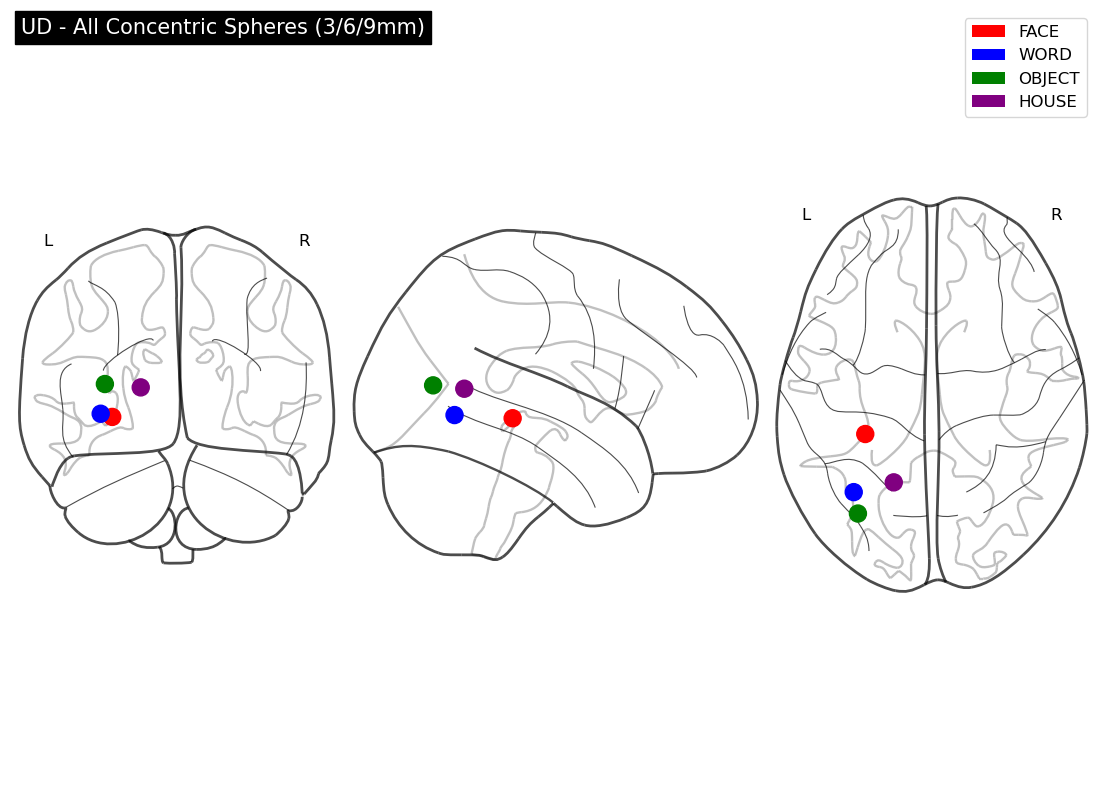

  Saved: UD_all_spheres.png


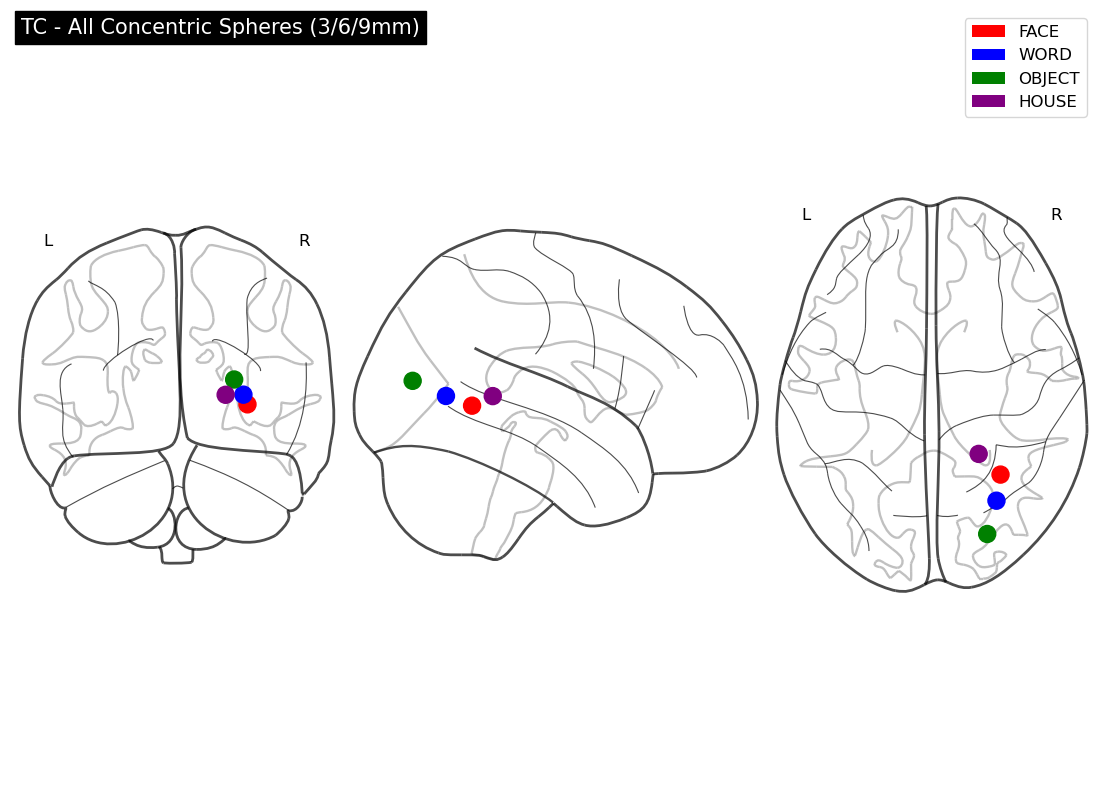

  Saved: TC_all_spheres.png


In [30]:
# COMPLETE STANDALONE CELL - ROI Extraction with Concentric Spheres + Visualization
import numpy as np
import nibabel as nib
from pathlib import Path
from scipy.ndimage import center_of_mass, label
import matplotlib.pyplot as plt
from nilearn import plotting

BASE_DIR = Path("/user_data/csimmon2/long_pt")
OUTPUT_DIR = BASE_DIR / "analyses" / "rsa_corrected"

SUBJECTS = {
    'sub-004': {'code': 'UD', 'sessions': ['01', '02', '03', '05', '06'], 'hemi': 'l'},
    'sub-021': {'code': 'TC', 'sessions': ['01', '02', '03'], 'hemi': 'r'}
}

def extract_functional_rois_final(subject_id, threshold_z=2.3):
    """Extract functional cluster ROIs across all sessions"""
    code = SUBJECTS[subject_id]['code']
    hemi = SUBJECTS[subject_id]['hemi']
    sessions = SUBJECTS[subject_id]['sessions']
    
    print(f"\n{'='*70}")
    print(f"{code} - Functional Clusters (z>{threshold_z})")
    print(f"{'='*70}")
    
    all_results = {}
    
    for category, cope_num in [('face', 10), ('word', 12), ('object', 3), ('house', 11)]:
        print(f"\n{category.upper()}:")
        all_results[category] = {}
        
        mask_file = BASE_DIR / subject_id / 'ses-01' / 'ROIs' / f'{hemi}_{category}_searchmask.nii.gz'
        if not mask_file.exists():
            print(f"  ⚠️  Mask not found")
            continue
        
        mask = nib.load(mask_file).get_fdata() > 0
        affine = nib.load(mask_file).affine
        
        for session in sessions:
            feat_dir = BASE_DIR / subject_id / f'ses-{session}' / 'derivatives' / 'fsl' / 'loc' / 'HighLevel.gfeat'
            zstat_file = 'zstat1.nii.gz' if session == '01' else 'zstat1_ses01.nii.gz'
            cope_file = feat_dir / f'cope{cope_num}.feat' / 'stats' / zstat_file
            
            if not cope_file.exists():
                continue
            
            zstat = nib.load(cope_file).get_fdata()
            suprathresh = (zstat > threshold_z) & mask
            
            if suprathresh.sum() < 50:
                print(f"  ses-{session}: <50 voxels (skipped)")
                continue
            
            labeled, n = label(suprathresh)
            sizes = [(labeled == i).sum() for i in range(1, n+1)]
            largest_idx = np.argmax(sizes) + 1
            roi_mask = (labeled == largest_idx)
            
            peak_idx = np.unravel_index(np.argmax(zstat * roi_mask), zstat.shape)
            peak_z = zstat[peak_idx]
            centroid = nib.affines.apply_affine(affine, center_of_mass(roi_mask))
            
            all_results[category][session] = {
                'n_voxels': sizes[largest_idx-1],
                'peak_z': peak_z,
                'centroid': centroid,
                'roi_mask': roi_mask
            }
            
            print(f"  ses-{session}: {sizes[largest_idx-1]:4d} voxels, peak z={peak_z:.2f}")
    
    return all_results


def extract_concentric_spheres_final(subject_id, functional_results, radii=[3, 6, 9]):
    """Create concentric spheres - uses ses-02 baseline for UD word"""
    code = SUBJECTS[subject_id]['code']
    hemi = SUBJECTS[subject_id]['hemi']
    sessions = SUBJECTS[subject_id]['sessions']
    
    mask_file = BASE_DIR / subject_id / 'ses-01' / 'ROIs' / f'{hemi}_face_searchmask.nii.gz'
    ref_img = nib.load(mask_file)
    affine = ref_img.affine
    
    print(f"\n{'='*70}")
    print(f"{code} - Concentric Spheres (r={radii}mm)")
    print(f"{'='*70}")
    
    sphere_results = {}
    
    for category, cope_num in [('face', 10), ('word', 12), ('object', 3), ('house', 11)]:
        
        # Use ses-02 baseline for UD word (no ses-01 peak)
        baseline = '02' if (category == 'word' and subject_id == 'sub-004') else '01'
        
        if category not in functional_results or baseline not in functional_results[category]:
            print(f"\n{category.upper()}: No ses-{baseline} peak, skipping")
            continue
        
        peak = functional_results[category][baseline]['centroid']
        baseline_note = " (ses-02 baseline)" if baseline == '02' else ""
        print(f"\n{category.upper()}: Peak at {peak}{baseline_note}")
        
        brain_shape = ref_img.shape
        grid_coords = np.array(np.meshgrid(
            np.arange(brain_shape[0]),
            np.arange(brain_shape[1]),
            np.arange(brain_shape[2]),
            indexing='ij'
        )).reshape(3, -1).T
        
        grid_world = nib.affines.apply_affine(affine, grid_coords)
        distances = np.linalg.norm(grid_world - peak, axis=1)
        
        sphere_masks = {}
        for r in radii:
            mask_3d = np.zeros(brain_shape, dtype=bool)
            within = grid_coords[distances <= r]
            for coord in within:
                mask_3d[coord[0], coord[1], coord[2]] = True
            sphere_masks[r] = mask_3d
            print(f"  {r}mm sphere: {np.sum(sphere_masks[r])} voxels")
        
        selectivity = {r: {} for r in radii}
        
        for session in sessions:
            feat_dir = BASE_DIR / subject_id / f'ses-{session}' / 'derivatives' / 'fsl' / 'loc' / 'HighLevel.gfeat'
            zstat_file = 'zstat1.nii.gz' if session == '01' else 'zstat1_ses01.nii.gz'
            cope_file = feat_dir / f'cope{cope_num}.feat' / 'stats' / zstat_file
            
            if not cope_file.exists():
                continue
            
            zstat = nib.load(cope_file).get_fdata()
            
            for r in radii:
                mean_z = zstat[sphere_masks[r]].mean()
                selectivity[r][session] = mean_z
        
        print(f"  Selectivity trajectory:")
        for r in radii:
            if r in selectivity and len(selectivity[r]) > 0:
                vals = [selectivity[r][s] for s in sessions if s in selectivity[r]]
                print(f"    {r}mm: {' → '.join([f'{v:.2f}' for v in vals])}")
        
        sphere_results[category] = {
            'peak': peak,
            'baseline_session': baseline,
            'selectivity': selectivity
        }
    
    return sphere_results


def visualize_all_spheres(subject_id, sphere_results):
    """All concentric spheres on one glass brain"""
    code = SUBJECTS[subject_id]['code']
    
    fig, ax = plt.subplots(figsize=(14, 10))
    
    all_peaks = []
    all_colors = []
    all_sizes = []
    
    color_map = {'face': 'red', 'word': 'blue', 'object': 'green', 'house': 'purple'}
    
    for cat in ['face', 'word', 'object', 'house']:
        if cat not in sphere_results[subject_id]:
            continue
        
        peak = sphere_results[subject_id][cat]['peak']
        
        # Add 3 concentric spheres
        for r, size in [(3, 50), (6, 100), (9, 150)]:
            all_peaks.append(peak)
            all_colors.append(color_map[cat])
            all_sizes.append(size)
    
    if len(all_peaks) == 0:
        return
    
    all_peaks = np.array(all_peaks)
    adjacency = np.zeros((len(all_peaks), len(all_peaks)))
    
    plotting.plot_connectome(adjacency, all_peaks,
                            node_color=all_colors, node_size=all_sizes,
                            axes=ax, colorbar=False,
                            title=f'{code} - All Concentric Spheres (3/6/9mm)')
    
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor=color_map[cat], label=cat.upper())
                      for cat in ['face', 'word', 'object', 'house']
                      if cat in sphere_results[subject_id]]
    ax.legend(handles=legend_elements, loc='upper right', fontsize=12)
    
    
    #plt.savefig(OUTPUT_DIR / f'{code}_all_spheres.png', dpi=300, bbox_inches='tight')
    plt.show()
    print(f"  Saved: {code}_all_spheres.png")


# RUN EXTRACTION
golarai_functional_final = {}
golarai_spheres_final = {}

for subj in ['sub-004', 'sub-021']:
    golarai_functional_final[subj] = extract_functional_rois_final(subj, threshold_z=2.3)
    golarai_spheres_final[subj] = extract_concentric_spheres_final(
        subj, golarai_functional_final[subj], radii=[3, 6, 9]
    )

print("\n✓ Extraction complete!")

# Generate visualizations
print("\nGenerating glass brain plots...")
for subj in ['sub-004', 'sub-021']:
    visualize_all_spheres(subj, golarai_spheres_final)

UD FACE ROI: extracted 913 voxels × 5 sessions


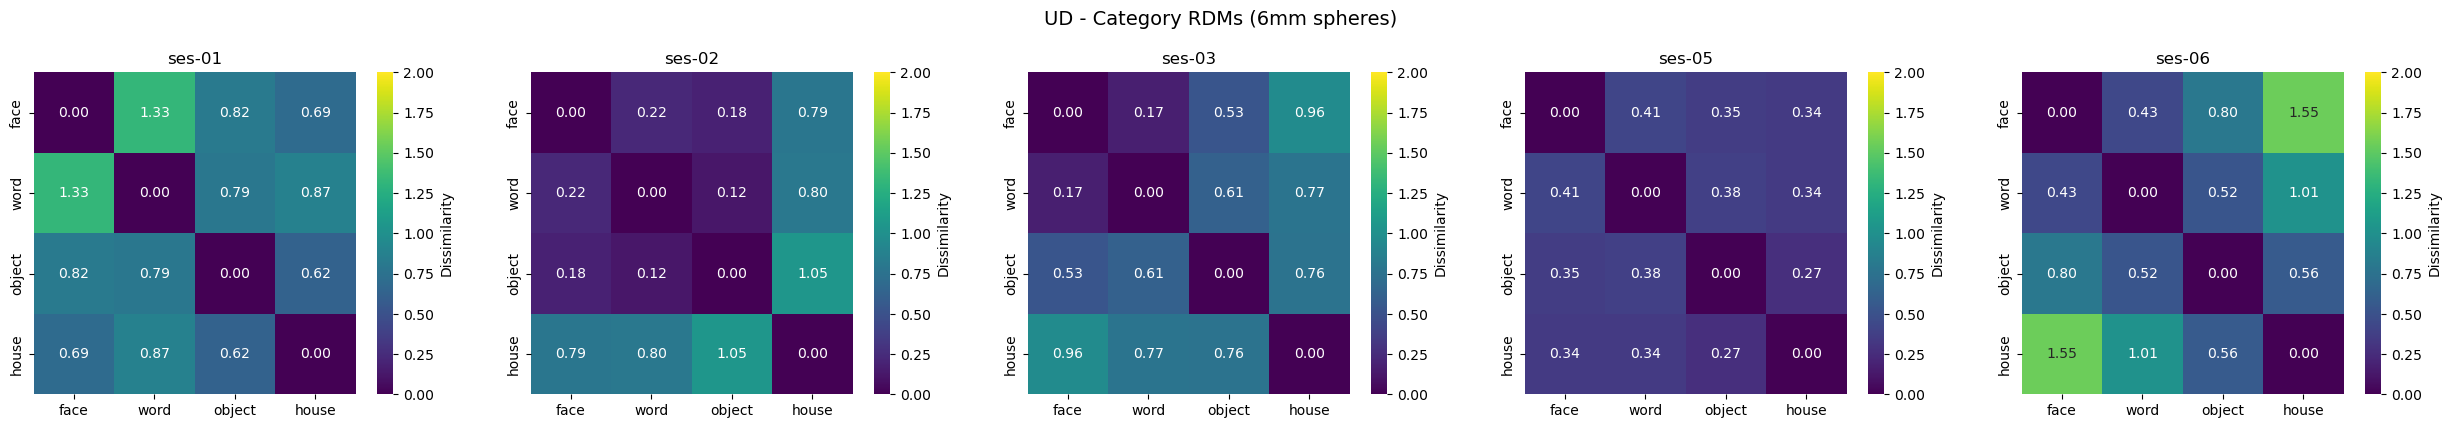

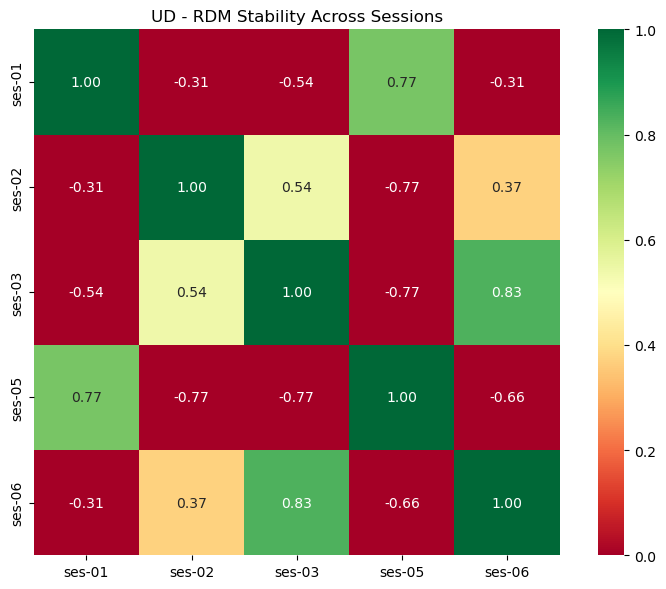


UD RDM correlation with baseline:
  ses-01 vs ses-02: r=-0.314
  ses-01 vs ses-03: r=-0.543
  ses-01 vs ses-05: r=0.771
  ses-01 vs ses-06: r=-0.314
TC FACE ROI: extracted 900 voxels × 3 sessions


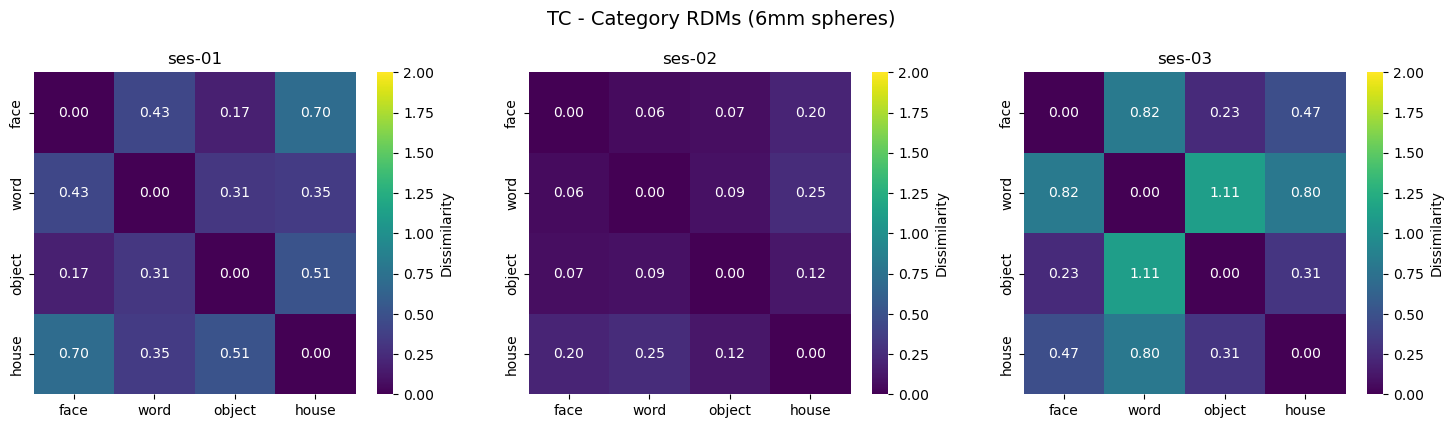

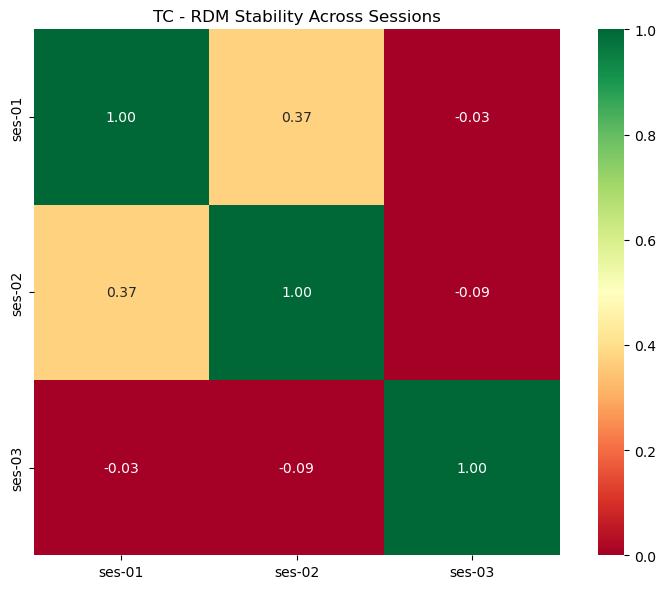


TC RDM correlation with baseline:
  ses-01 vs ses-02: r=0.371
  ses-01 vs ses-03: r=-0.029


In [33]:
def extract_patterns_single_roi(subject_id, sphere_results, roi_name='face', radius=6):
    """
    Extract ALL category patterns from a single sphere ROI
    roi_name: which sphere to use as the ROI ('face', 'word', 'object', 'house')
    """
    code = SUBJECTS[subject_id]['code']
    sessions = SUBJECTS[subject_id]['sessions']
    hemi = SUBJECTS[subject_id]['hemi']
    
    if roi_name not in sphere_results[subject_id]:
        return None
    
    # Get the sphere location
    peak = sphere_results[subject_id][roi_name]['peak']
    
    # Create sphere mask
    mask_file = BASE_DIR / subject_id / 'ses-01' / 'ROIs' / f'{hemi}_face_searchmask.nii.gz'
    ref_img = nib.load(mask_file)
    affine = ref_img.affine
    brain_shape = ref_img.shape
    
    grid_coords = np.array(np.meshgrid(
        np.arange(brain_shape[0]),
        np.arange(brain_shape[1]),
        np.arange(brain_shape[2]),
        indexing='ij'
    )).reshape(3, -1).T
    
    grid_world = nib.affines.apply_affine(affine, grid_coords)
    distances = np.linalg.norm(grid_world - peak, axis=1)
    
    sphere_mask = np.zeros(brain_shape, dtype=bool)
    within = grid_coords[distances <= radius]
    for coord in within:
        sphere_mask[coord[0], coord[1], coord[2]] = True
    
    # Extract ALL categories from this ROI
    patterns = {cat: {} for cat in ['face', 'word', 'object', 'house']}
    
    for category, cope_num in [('face', 10), ('word', 12), ('object', 3), ('house', 11)]:
        for session in sessions:
            feat_dir = BASE_DIR / subject_id / f'ses-{session}' / 'derivatives' / 'fsl' / 'loc' / 'HighLevel.gfeat'
            cope_file = feat_dir / f'cope{cope_num}.feat' / 'stats' / 'cope1.nii.gz'
            
            if not cope_file.exists():
                continue
            
            cope = nib.load(cope_file).get_fdata()
            patterns[category][session] = cope[sphere_mask]
    
    print(f"{code} {roi_name.upper()} ROI: extracted {np.sum(sphere_mask)} voxels × {len(sessions)} sessions")
    return patterns


# Run for face ROI
for subj in ['sub-004', 'sub-021']:
    patterns = extract_patterns_single_roi(subj, golarai_spheres_final, roi_name='face', radius=6)
    if patterns:
        visualize_rdms(subj, patterns, OUTPUT_DIR)
        compare_rdms_across_sessions(subj, patterns)


EXTRACTING PATTERNS: UD - FACE ROI
Subject: sub-004 (UD)
Hemisphere: l
Sessions available: ['01', '02', '03', '05', '06']
Sphere radius: 6mm
Peak coordinate (MNI): [-29.67897727 -34.36079545  -4.47159091]
Brain shape: (176, 256, 256)
✓ Sphere mask created: 913 voxels

Extracting category patterns:

  FACE (cope10):
    ses-01: ✓ shape=(913,), mean=41.255, std=23.261
    ses-02: ✓ shape=(913,), mean=3.120, std=9.089
    ses-03: ✓ shape=(913,), mean=9.336, std=15.998
    ses-05: ✓ shape=(913,), mean=2.070, std=12.303
    ses-06: ✓ shape=(913,), mean=0.388, std=11.757
  → face: 5/5 sessions extracted

  WORD (cope12):
    ses-01: ✓ shape=(913,), mean=-6.852, std=23.874
    ses-02: ✓ shape=(913,), mean=2.515, std=10.533
    ses-03: ✓ shape=(913,), mean=7.727, std=13.792
    ses-05: ✓ shape=(913,), mean=2.422, std=12.953
    ses-06: ✓ shape=(913,), mean=-2.526, std=9.672
  → word: 5/5 sessions extracted

  OBJECT (cope3):
    ses-01: ✓ shape=(913,), mean=30.869, std=23.216
    ses-02: ✓ sh

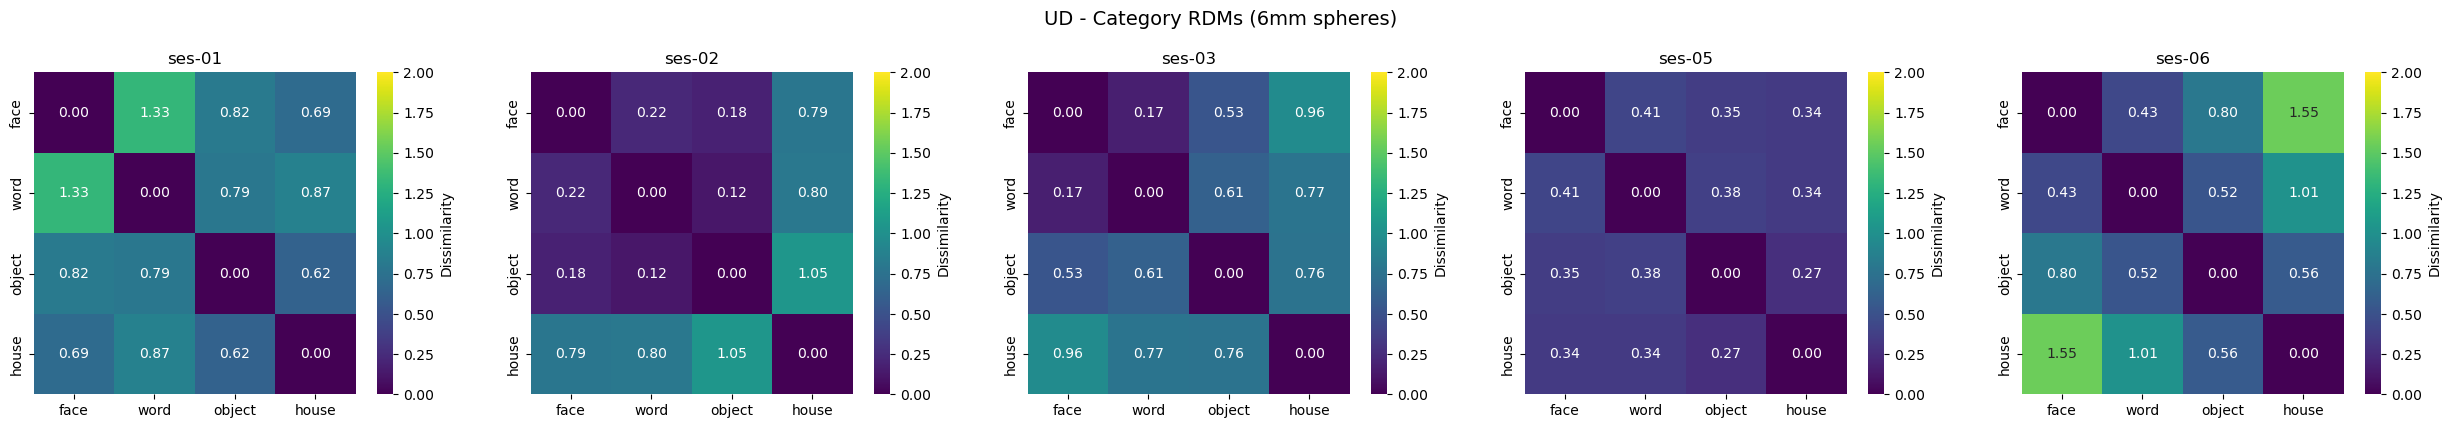


EXTRACTING PATTERNS: TC - FACE ROI
Subject: sub-021 (TC)
Hemisphere: r
Sessions available: ['01', '02', '03']
Sphere radius: 6mm
Peak coordinate (MNI): [ 32.63768874 -53.05352071   1.32127373]
Brain shape: (176, 256, 256)
✓ Sphere mask created: 900 voxels

Extracting category patterns:

  FACE (cope10):
    ses-01: ✓ shape=(900,), mean=135.183, std=73.541
    ses-02: ✓ shape=(900,), mean=62.365, std=83.983
    ses-03: ✓ shape=(900,), mean=0.253, std=17.586
  → face: 3/3 sessions extracted

  WORD (cope12):
    ses-01: ✓ shape=(900,), mean=8.390, std=20.461
    ses-02: ✓ shape=(900,), mean=39.061, std=44.462
    ses-03: ✓ shape=(900,), mean=-5.182, std=11.280
  → word: 3/3 sessions extracted

  OBJECT (cope3):
    ses-01: ✓ shape=(900,), mean=65.094, std=65.058
    ses-02: ✓ shape=(900,), mean=58.066, std=63.070
    ses-03: ✓ shape=(900,), mean=5.677, std=11.307
  → object: 3/3 sessions extracted

  HOUSE (cope11):
    ses-01: ✓ shape=(900,), mean=-1.514, std=13.580
    ses-02: ✓ shape

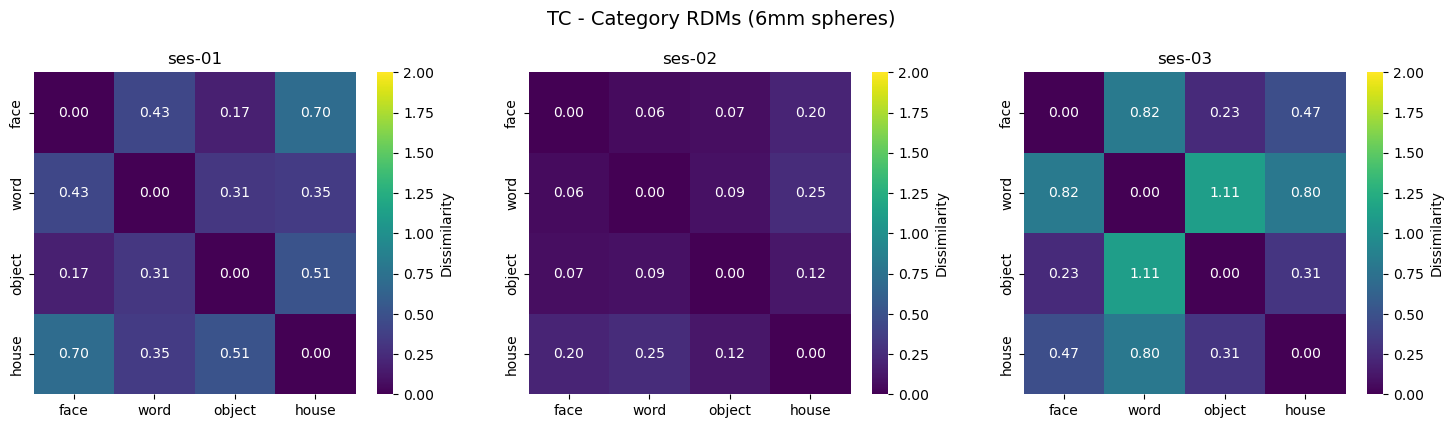

In [36]:
def extract_patterns_single_roi(subject_id, sphere_results, roi_name='face', radius=6):
    """
    Extract ALL category patterns from a single sphere ROI
    roi_name: which sphere to use as the ROI ('face', 'word', 'object', 'house')
    """
    code = SUBJECTS[subject_id]['code']
    sessions = SUBJECTS[subject_id]['sessions']
    hemi = SUBJECTS[subject_id]['hemi']
    
    print(f"\n{'='*60}")
    print(f"EXTRACTING PATTERNS: {code} - {roi_name.upper()} ROI")
    print(f"{'='*60}")
    print(f"Subject: {subject_id} ({code})")
    print(f"Hemisphere: {hemi}")
    print(f"Sessions available: {sessions}")
    print(f"Sphere radius: {radius}mm")
    
    if roi_name not in sphere_results[subject_id]:
        print(f"❌ {roi_name.upper()} ROI not found in sphere_results")
        return None
    
    # Get the sphere location
    peak = sphere_results[subject_id][roi_name]['peak']
    print(f"Peak coordinate (MNI): {peak}")
    
    # Create sphere mask
    mask_file = BASE_DIR / subject_id / 'ses-01' / 'ROIs' / f'{hemi}_face_searchmask.nii.gz'
    ref_img = nib.load(mask_file)
    affine = ref_img.affine
    brain_shape = ref_img.shape
    print(f"Brain shape: {brain_shape}")
    
    grid_coords = np.array(np.meshgrid(
        np.arange(brain_shape[0]),
        np.arange(brain_shape[1]),
        np.arange(brain_shape[2]),
        indexing='ij'
    )).reshape(3, -1).T
    
    grid_world = nib.affines.apply_affine(affine, grid_coords)
    distances = np.linalg.norm(grid_world - peak, axis=1)
    
    sphere_mask = np.zeros(brain_shape, dtype=bool)
    within = grid_coords[distances <= radius]
    for coord in within:
        sphere_mask[coord[0], coord[1], coord[2]] = True
    
    n_voxels = np.sum(sphere_mask)
    print(f"✓ Sphere mask created: {n_voxels} voxels")
    
    # Extract ALL categories from this ROI
    patterns = {cat: {} for cat in ['face', 'word', 'object', 'house']}
    
    print(f"\nExtracting category patterns:")
    for category, cope_num in [('face', 10), ('word', 12), ('object', 3), ('house', 11)]:
        print(f"\n  {category.upper()} (cope{cope_num}):")
        sessions_found = []
        
        for session in sessions:
            feat_dir = BASE_DIR / subject_id / f'ses-{session}' / 'derivatives' / 'fsl' / 'loc' / 'HighLevel.gfeat'
            cope_file = feat_dir / f'cope{cope_num}.feat' / 'stats' / 'cope1.nii.gz'
            
            if not cope_file.exists():
                print(f"    ses-{session}: ❌ NOT FOUND")
                continue
            
            cope = nib.load(cope_file).get_fdata()
            patterns[category][session] = cope[sphere_mask]
            sessions_found.append(session)
            
            # Pattern statistics
            pattern_mean = np.mean(patterns[category][session])
            pattern_std = np.std(patterns[category][session])
            print(f"    ses-{session}: ✓ shape={patterns[category][session].shape}, "
                  f"mean={pattern_mean:.3f}, std={pattern_std:.3f}")
        
        print(f"  → {category}: {len(sessions_found)}/{len(sessions)} sessions extracted")
    
    print(f"\n{'='*60}")
    print(f"EXTRACTION COMPLETE: {code} {roi_name.upper()} ROI")
    print(f"{n_voxels} voxels × {len(sessions)} sessions")
    print(f"{'='*60}\n")
    
    return patterns


def compare_rdms_across_sessions(subject_id, patterns):
    """
    Compute RDM correlations between baseline (ses-01) and all other sessions
    """
    code = SUBJECTS[subject_id]['code']
    sessions = sorted([s for s in patterns['face'].keys()])
    
    print(f"\n{'='*60}")
    print(f"RDM CORRELATION ANALYSIS: {code}")
    print(f"{'='*60}")
    print(f"Available sessions: {sessions}")
    print(f"Baseline session: ses-{sessions[0]}")
    
    if len(sessions) < 2:
        print("❌ Need at least 2 sessions for correlation analysis")
        return
    
    # Compute RDM for each session
    rdms = {}
    for session in sessions:
        print(f"\nComputing RDM for ses-{session}:")
        
        # Stack patterns: [n_categories x n_voxels]
        session_patterns = []
        categories_order = ['face', 'word', 'object', 'house']
        
        for cat in categories_order:
            if session in patterns[cat]:
                session_patterns.append(patterns[cat][session])
                print(f"  {cat}: {patterns[cat][session].shape}")
            else:
                print(f"  {cat}: ❌ MISSING")
        
        if len(session_patterns) == 4:
            pattern_matrix = np.array(session_patterns)  # [4 x n_voxels]
            print(f"  Pattern matrix shape: {pattern_matrix.shape}")
            
            # Compute RDM: 1 - correlation
            rdm = 1 - np.corrcoef(pattern_matrix)
            rdms[session] = rdm
            
            print(f"  RDM shape: {rdm.shape}")
            print(f"  RDM range: [{np.min(rdm):.3f}, {np.max(rdm):.3f}]")
            print(f"  RDM diagonal (should be ~0): {np.diag(rdm)}")
    
    # Compare all sessions to baseline
    baseline_session = sessions[0]
    baseline_rdm = rdms[baseline_session]
    
    # Flatten upper triangle for correlation
    triu_idx = np.triu_indices(4, k=1)
    baseline_vector = baseline_rdm[triu_idx]
    
    print(f"\n{'='*60}")
    print(f"{code} RDM CORRELATION WITH BASELINE (ses-{baseline_session}):")
    print(f"{'='*60}")
    print(f"Upper triangle elements: {len(baseline_vector)}")
    print(f"Baseline RDM vector: {baseline_vector}")
    
    for session in sessions[1:]:
        if session in rdms:
            session_vector = rdms[session][triu_idx]
            correlation = np.corrcoef(baseline_vector, session_vector)[0, 1]
            
            print(f"  ses-{baseline_session} vs ses-{session}: r={correlation:.3f}")
            print(f"    Session {session} RDM vector: {session_vector}")
    
    print(f"{'='*60}\n")
# Run with enhanced print statements
for subj in ['sub-004', 'sub-021']:
    patterns = extract_patterns_single_roi(subj, golarai_spheres_final, roi_name='face', radius=6)
    if patterns:
        compare_rdms_across_sessions(subj, patterns)
        visualize_rdms(subj, patterns, OUTPUT_DIR)

In [39]:
def extract_and_analyze_rois_zscore(subject_id, sphere_results, radius=6):
    """Extract patterns, z-score them, compute RDM correlations with Fisher transform"""
    code = SUBJECTS[subject_id]['code']
    sessions = SUBJECTS[subject_id]['sessions']
    hemi = SUBJECTS[subject_id]['hemi']
    
    available_rois = [roi for roi in ['face', 'word', 'object', 'house'] 
                      if roi in sphere_results[subject_id]]
    
    print(f"\n{'='*70}")
    print(f"{code}: ANALYZING {len(available_rois)} ROIs WITH Z-SCORED PATTERNS")
    print(f"{'='*70}\n")
    
    # Extract and z-score patterns for all ROIs
    all_roi_data = {}
    
    for roi_name in available_rois:
        peak = sphere_results[subject_id][roi_name]['peak']
        
        # Create sphere mask
        mask_file = BASE_DIR / subject_id / 'ses-01' / 'ROIs' / f'{hemi}_face_searchmask.nii.gz'
        ref_img = nib.load(mask_file)
        affine = ref_img.affine
        brain_shape = ref_img.shape
        
        grid_coords = np.array(np.meshgrid(
            np.arange(brain_shape[0]),
            np.arange(brain_shape[1]),
            np.arange(brain_shape[2]),
            indexing='ij'
        )).reshape(3, -1).T
        
        grid_world = nib.affines.apply_affine(affine, grid_coords)
        distances = np.linalg.norm(grid_world - peak, axis=1)
        
        sphere_mask = np.zeros(brain_shape, dtype=bool)
        within = grid_coords[distances <= radius]
        for coord in within:
            sphere_mask[coord[0], coord[1], coord[2]] = True
        
        n_voxels = np.sum(sphere_mask)
        
        # Extract patterns for all categories and sessions
        patterns = {cat: {} for cat in ['face', 'word', 'object', 'house']}
        z_patterns = {cat: {} for cat in ['face', 'word', 'object', 'house']}
        
        for category, cope_num in [('face', 10), ('word', 12), ('object', 3), ('house', 11)]:
            for session in sessions:
                feat_dir = BASE_DIR / subject_id / f'ses-{session}' / 'derivatives' / 'fsl' / 'loc' / 'HighLevel.gfeat'
                cope_file = feat_dir / f'cope{cope_num}.feat' / 'stats' / 'cope1.nii.gz'
                
                if cope_file.exists():
                    cope = nib.load(cope_file).get_fdata()
                    pattern = cope[sphere_mask]
                    patterns[category][session] = pattern
                    
                    # Z-score: (pattern - mean) / std
                    z_pattern = (pattern - np.mean(pattern)) / np.std(pattern)
                    z_patterns[category][session] = z_pattern
        
        print(f"{roi_name.upper()} ROI: {n_voxels} voxels")
        
        # Compute RDMs from z-scored patterns
        rdms = {}
        for session in sessions:
            session_z_patterns = []
            for cat in ['face', 'word', 'object', 'house']:
                if session in z_patterns[cat]:
                    session_z_patterns.append(z_patterns[cat][session])
            
            if len(session_z_patterns) == 4:
                pattern_matrix = np.array(session_z_patterns)  # [4 x n_voxels]
                rdm = 1 - np.corrcoef(pattern_matrix)
                rdms[session] = rdm
        
        # Compute correlations with baseline
        baseline_session = sessions[0]
        if baseline_session in rdms and len(rdms) > 1:
            baseline_rdm = rdms[baseline_session]
            triu_idx = np.triu_indices(4, k=1)
            baseline_vector = baseline_rdm[triu_idx]
            
            correlations = {}
            fisher_z = {}
            
            print(f"  Baseline RDM: {baseline_vector}")
            
            for session in sessions[1:]:
                if session in rdms:
                    session_vector = rdms[session][triu_idx]
                    r = np.corrcoef(baseline_vector, session_vector)[0, 1]
                    z = 0.5 * np.log((1 + r) / (1 - r))  # Fisher transform
                    
                    correlations[session] = r
                    fisher_z[session] = z
                    print(f"    ses-{baseline_session} vs ses-{session}: r={r:.3f}, z={z:.3f}")
            
            all_roi_data[roi_name] = {
                'n_voxels': n_voxels,
                'patterns': patterns,
                'z_patterns': z_patterns,
                'rdms': rdms,
                'correlations': correlations,
                'fisher_z': fisher_z
            }
        print()
    
    # Summary table
    print(f"{'='*70}")
    print(f"{code}: SUMMARY (r / Fisher z)")
    print(f"{'='*70}")
    
    all_sessions = sorted(set(s for roi_data in all_roi_data.values() 
                             for s in roi_data['correlations'].keys()))
    
    header = f"{'ROI':<10}" + "".join([f"ses-{s:>12}" for s in all_sessions])
    print(header)
    print("-" * len(header))
    
    for roi_name, roi_data in all_roi_data.items():
        row = f"{roi_name.upper():<10}"
        for session in all_sessions:
            if session in roi_data['correlations']:
                r = roi_data['correlations'][session]
                z = roi_data['fisher_z'][session]
                row += f"{r:>5.2f}/{z:>5.2f}"
            else:
                row += f"{'---':>12}"
        print(row)
    
    print(f"{'='*70}\n")
    
    return all_roi_data


# Run analysis
for subj in ['sub-004', 'sub-021']:
    results = extract_and_analyze_rois_zscore(subj, golarai_spheres_final, radius=6)


UD: ANALYZING 4 ROIs WITH Z-SCORED PATTERNS



FACE ROI: 913 voxels
  Baseline RDM: [1.32802763 0.81859874 0.68924833 0.79148286 0.86732519 0.62001009]
    ses-01 vs ses-02: r=-0.539, z=-0.603
    ses-01 vs ses-03: r=-0.873, z=-1.346
    ses-01 vs ses-05: r=0.818, z=1.149
    ses-01 vs ses-06: r=-0.425, z=-0.454

WORD ROI: 898 voxels
  Baseline RDM: [0.52596989 0.52203984 0.31089508 0.45809885 0.4609891  0.31660581]
    ses-01 vs ses-02: r=-0.887, z=-1.408
    ses-01 vs ses-03: r=0.583, z=0.667
    ses-01 vs ses-05: r=0.145, z=0.146
    ses-01 vs ses-06: r=-0.547, z=-0.614

OBJECT ROI: 905 voxels
  Baseline RDM: [0.96893218 1.04529365 0.7619175  0.66758092 1.08104645 0.7940871 ]
    ses-01 vs ses-02: r=-0.055, z=-0.055
    ses-01 vs ses-03: r=-0.085, z=-0.086
    ses-01 vs ses-05: r=-0.087, z=-0.087
    ses-01 vs ses-06: r=0.224, z=0.228

HOUSE ROI: 898 voxels
  Baseline RDM: [0.47106193 0.81298019 0.23250248 0.84528773 0.7307578  0.57105599]
    ses-01 vs ses-02: r=0.310, z=0.321
    ses-01 vs ses-03: r=-0.084, z=-0.084
    ses-01

In [40]:
def check_within_session_reliability(subject_id, sphere_results, roi_name='face', radius=6, session='01'):
    """Split-half reliability: correlate RDMs from two random halves of voxels"""
    code = SUBJECTS[subject_id]['code']
    hemi = SUBJECTS[subject_id]['hemi']
    peak = sphere_results[subject_id][roi_name]['peak']
    
    # Create sphere mask
    mask_file = BASE_DIR / subject_id / 'ses-01' / 'ROIs' / f'{hemi}_face_searchmask.nii.gz'
    ref_img = nib.load(mask_file)
    affine = ref_img.affine
    brain_shape = ref_img.shape
    
    grid_coords = np.array(np.meshgrid(
        np.arange(brain_shape[0]),
        np.arange(brain_shape[1]),
        np.arange(brain_shape[2]),
        indexing='ij'
    )).reshape(3, -1).T
    
    grid_world = nib.affines.apply_affine(affine, grid_coords)
    distances = np.linalg.norm(grid_world - peak, axis=1)
    
    sphere_mask = np.zeros(brain_shape, dtype=bool)
    within = grid_coords[distances <= radius]
    for coord in within:
        sphere_mask[coord[0], coord[1], coord[2]] = True
    
    # Extract patterns
    patterns = {}
    for category, cope_num in [('face', 10), ('word', 12), ('object', 3), ('house', 11)]:
        feat_dir = BASE_DIR / subject_id / f'ses-{session}' / 'derivatives' / 'fsl' / 'loc' / 'HighLevel.gfeat'
        cope_file = feat_dir / f'cope{cope_num}.feat' / 'stats' / 'cope1.nii.gz'
        
        if cope_file.exists():
            cope = nib.load(cope_file).get_fdata()
            pattern = cope[sphere_mask]
            z_pattern = (pattern - np.mean(pattern)) / np.std(pattern)
            patterns[category] = z_pattern
    
    if len(patterns) != 4:
        return None
    
    # Split voxels in half randomly
    n_voxels = len(patterns['face'])
    indices = np.arange(n_voxels)
    np.random.seed(42)
    np.random.shuffle(indices)
    
    half1_idx = indices[:n_voxels//2]
    half2_idx = indices[n_voxels//2:]
    
    # Compute RDMs from each half
    half1_patterns = np.array([patterns[cat][half1_idx] for cat in ['face', 'word', 'object', 'house']])
    half2_patterns = np.array([patterns[cat][half2_idx] for cat in ['face', 'word', 'object', 'house']])
    
    rdm1 = 1 - np.corrcoef(half1_patterns)
    rdm2 = 1 - np.corrcoef(half2_patterns)
    
    # Correlate upper triangles
    triu_idx = np.triu_indices(4, k=1)
    r = np.corrcoef(rdm1[triu_idx], rdm2[triu_idx])[0, 1]
    
    return r, n_voxels


# Test reliability and radius
for subj in ['sub-004', 'sub-021']:
    code = SUBJECTS[subj]['code']
    sessions = SUBJECTS[subj]['sessions']
    
    print(f"\n{'='*70}")
    print(f"{code}: SPLIT-HALF RELIABILITY & RADIUS COMPARISON")
    print(f"{'='*70}\n")
    
    # Reliability check for face ROI across sessions and radii
    print("Split-half reliability (face ROI):")
    print(f"{'Session':<10}{'r=6mm':<15}{'r=8mm':<15}{'r=10mm':<15}")
    print("-" * 55)
    
    for session in sessions[:3]:  # First 3 sessions
        row = f"ses-{session:<7}"
        for radius in [6, 8, 10]:
            result = check_within_session_reliability(subj, golarai_spheres_final, 'face', radius, session)
            if result:
                r, n_vox = result
                row += f"{r:.3f}({n_vox:>4}v) "
            else:
                row += f"{'---':<15}"
        print(row)
    
    print(f"\n{'-'*70}\n")
    
    # Full analysis at different radii
    for radius in [6, 8, 10]:
        print(f"Radius = {radius}mm:")
        results = extract_and_analyze_rois_zscore(subj, golarai_spheres_final, radius=radius)


UD: SPLIT-HALF RELIABILITY & RADIUS COMPARISON

Split-half reliability (face ROI):
Session   r=6mm          r=8mm          r=10mm         
-------------------------------------------------------
ses-01     0.971( 913v) 0.978(2142v) 0.979(4197v) 
ses-02     0.991( 913v) 0.998(2142v) 0.997(4197v) 
ses-03     0.992( 913v) 0.989(2142v) 0.997(4197v) 

----------------------------------------------------------------------

Radius = 6mm:

UD: ANALYZING 4 ROIs WITH Z-SCORED PATTERNS

FACE ROI: 913 voxels
  Baseline RDM: [1.32802763 0.81859874 0.68924833 0.79148286 0.86732519 0.62001009]
    ses-01 vs ses-02: r=-0.539, z=-0.603
    ses-01 vs ses-03: r=-0.873, z=-1.346
    ses-01 vs ses-05: r=0.818, z=1.149
    ses-01 vs ses-06: r=-0.425, z=-0.454

WORD ROI: 898 voxels
  Baseline RDM: [0.52596989 0.52203984 0.31089508 0.45809885 0.4609891  0.31660581]
    ses-01 vs ses-02: r=-0.887, z=-1.408
    ses-01 vs ses-03: r=0.583, z=0.667
    ses-01 vs ses-05: r=0.145, z=0.146
    ses-01 vs ses-06: r=-0

In [42]:
def compute_all_pairwise_rdm_correlations(subject_id, sphere_results, radius=10):
    """Compute RDM correlations for all session pairs, not just vs baseline"""
    code = SUBJECTS[subject_id]['code']
    sessions = SUBJECTS[subject_id]['sessions']
    hemi = SUBJECTS[subject_id]['hemi']
    
    available_rois = [roi for roi in ['face', 'word', 'object', 'house'] 
                      if roi in sphere_results[subject_id]]
    
    print(f"\n{'='*70}")
    print(f"{code}: ALL PAIRWISE SESSION COMPARISONS (10mm radius)")
    print(f"{'='*70}\n")
    
    for roi_name in available_rois:
        peak = sphere_results[subject_id][roi_name]['peak']
        
        # Create mask and extract patterns
        mask_file = BASE_DIR / subject_id / 'ses-01' / 'ROIs' / f'{hemi}_face_searchmask.nii.gz'
        ref_img = nib.load(mask_file)
        affine = ref_img.affine
        brain_shape = ref_img.shape
        
        grid_coords = np.array(np.meshgrid(
            np.arange(brain_shape[0]),
            np.arange(brain_shape[1]),
            np.arange(brain_shape[2]),
            indexing='ij'
        )).reshape(3, -1).T
        
        grid_world = nib.affines.apply_affine(affine, grid_coords)
        distances = np.linalg.norm(grid_world - peak, axis=1)
        
        sphere_mask = np.zeros(brain_shape, dtype=bool)
        within = grid_coords[distances <= radius]
        for coord in within:
            sphere_mask[coord[0], coord[1], coord[2]] = True
        
        # Extract z-scored patterns
        z_patterns = {cat: {} for cat in ['face', 'word', 'object', 'house']}
        
        for category, cope_num in [('face', 10), ('word', 12), ('object', 3), ('house', 11)]:
            for session in sessions:
                feat_dir = BASE_DIR / subject_id / f'ses-{session}' / 'derivatives' / 'fsl' / 'loc' / 'HighLevel.gfeat'
                cope_file = feat_dir / f'cope{cope_num}.feat' / 'stats' / 'cope1.nii.gz'
                
                if cope_file.exists():
                    cope = nib.load(cope_file).get_fdata()
                    pattern = cope[sphere_mask]
                    z_pattern = (pattern - np.mean(pattern)) / np.std(pattern)
                    z_patterns[category][session] = z_pattern
        
        # Compute RDMs for all sessions
        rdms = {}
        for session in sessions:
            session_patterns = [z_patterns[cat][session] for cat in ['face', 'word', 'object', 'house'] 
                              if session in z_patterns[cat]]
            if len(session_patterns) == 4:
                rdm = 1 - np.corrcoef(np.array(session_patterns))
                rdms[session] = rdm
        
        # All pairwise comparisons
        triu_idx = np.triu_indices(4, k=1)
        
        print(f"{roi_name.upper()} ROI:")
        print(f"  Sessions: {sessions}")
        
        # Create correlation matrix
        n_sessions = len(sessions)
        corr_matrix = np.ones((n_sessions, n_sessions))
        
        for i, sess_i in enumerate(sessions):
            for j, sess_j in enumerate(sessions):
                if i < j and sess_i in rdms and sess_j in rdms:
                    vec_i = rdms[sess_i][triu_idx]
                    vec_j = rdms[sess_j][triu_idx]
                    r = np.corrcoef(vec_i, vec_j)[0, 1]
                    z = 0.5 * np.log((1 + r) / (1 - r))
                    corr_matrix[i, j] = r
                    corr_matrix[j, i] = r
                    print(f"  ses-{sess_i} vs ses-{sess_j}: r={r:>6.3f}, z={z:>6.3f}")
        
        print()


# Run pairwise analysis
compute_all_pairwise_rdm_correlations('sub-004', golarai_spheres_final, radius=10)
compute_all_pairwise_rdm_correlations('sub-021', golarai_spheres_final, radius=10)


UD: ALL PAIRWISE SESSION COMPARISONS (10mm radius)

FACE ROI:
  Sessions: ['01', '02', '03', '05', '06']
  ses-01 vs ses-02: r=-0.853, z=-1.266
  ses-01 vs ses-03: r=-0.073, z=-0.074
  ses-01 vs ses-05: r=-0.518, z=-0.574
  ses-01 vs ses-06: r=-0.162, z=-0.163
  ses-02 vs ses-03: r= 0.103, z= 0.103
  ses-02 vs ses-05: r= 0.389, z= 0.410
  ses-02 vs ses-06: r= 0.165, z= 0.167
  ses-03 vs ses-05: r= 0.167, z= 0.169
  ses-03 vs ses-06: r= 0.648, z= 0.771
  ses-05 vs ses-06: r= 0.153, z= 0.154

WORD ROI:
  Sessions: ['01', '02', '03', '05', '06']
  ses-01 vs ses-02: r= 0.818, z= 1.151
  ses-01 vs ses-03: r= 0.626, z= 0.735
  ses-01 vs ses-05: r= 0.659, z= 0.791
  ses-01 vs ses-06: r= 0.685, z= 0.839
  ses-02 vs ses-03: r= 0.402, z= 0.426
  ses-02 vs ses-05: r= 0.649, z= 0.773
  ses-02 vs ses-06: r= 0.631, z= 0.743
  ses-03 vs ses-05: r= 0.020, z= 0.020
  ses-03 vs ses-06: r= 0.095, z= 0.095
  ses-05 vs ses-06: r= 0.971, z= 2.114

OBJECT ROI:
  Sessions: ['01', '02', '03', '05', '06']
  se

In [ ]:
def visualize_rdm_evolution(subject_id, sphere_results, radius=10):
    """Visualize how RDMs change across sessions for each ROI"""
    import matplotlib.pyplot as plt
    
    code = SUBJECTS[subject_id]['code']
    sessions = SUBJECTS[subject_id]['sessions']
    hemi = SUBJECTS[subject_id]['hemi']
    
    available_rois = [roi for roi in ['face', 'word', 'object', 'house'] 
                      if roi in sphere_results[subject_id]]
    
    for roi_name in available_rois:
        peak = sphere_results[subject_id][roi_name]['peak']
        
        # Create mask
        mask_file = BASE_DIR / subject_id / 'ses-01' / 'ROIs' / f'{hemi}_face_searchmask.nii.gz'
        ref_img = nib.load(mask_file)
        affine = ref_img.affine
        brain_shape = ref_img.shape
        
        grid_coords = np.array(np.meshgrid(
            np.arange(brain_shape[0]),
            np.arange(brain_shape[1]),
            np.arange(brain_shape[2]),
            indexing='ij'
        )).reshape(3, -1).T
        
        grid_world = nib.affines.apply_affine(affine, grid_coords)
        distances = np.linalg.norm(grid_world - peak, axis=1)
        
        sphere_mask = np.zeros(brain_shape, dtype=bool)
        within = grid_coords[distances <= radius]
        for coord in within:
            sphere_mask[coord[0], coord[1], coord[2]] = True
        
        # Extract patterns
        z_patterns = {cat: {} for cat in ['face', 'word', 'object', 'house']}
        
        for category, cope_num in [('face', 10), ('word', 12), ('object', 3), ('house', 11)]:
            for session in sessions:
                feat_dir = BASE_DIR / subject_id / f'ses-{session}' / 'derivatives' / 'fsl' / 'loc' / 'HighLevel.gfeat'
                cope_file = feat_dir / f'cope{cope_num}.feat' / 'stats' / 'cope1.nii.gz'
                
                if cope_file.exists():
                    cope = nib.load(cope_file).get_fdata()
                    pattern = cope[sphere_mask]
                    z_pattern = (pattern - np.mean(pattern)) / np.std(pattern)
                    z_patterns[category][session] = z_pattern
        
        # Compute RDMs
        rdms = {}
        for session in sessions:
            session_patterns = [z_patterns[cat][session] for cat in ['face', 'word', 'object', 'house'] 
                              if session in z_patterns[cat]]
            if len(session_patterns) == 4:
                rdm = 1 - np.corrcoef(np.array(session_patterns))
                rdms[session] = rdm
        
        # Plot RDMs
        n_sessions = len(rdms)
        fig, axes = plt.subplots(1, n_sessions, figsize=(4*n_sessions, 4))
        if n_sessions == 1:
            axes = [axes]
        
        categories = ['Face', 'Word', 'Object', 'House']
        
        for i, (session, rdm) in enumerate(sorted(rdms.items())):
            im = axes[i].imshow(rdm, cmap='hot', vmin=0, vmax=2)
            axes[i].set_title(f'{code} {roi_name.upper()}\nses-{session}', fontsize=12, fontweight='bold')
            axes[i].set_xticks(range(4))
            axes[i].set_yticks(range(4))
            axes[i].set_xticklabels(categories, rotation=45, ha='right')
            axes[i].set_yticklabels(categories)
            
            # Add values
            for r in range(4):
                for c in range(4):
                    axes[i].text(c, r, f'{rdm[r,c]:.2f}', 
                               ha='center', va='center', 
                               color='white' if rdm[r,c] > 1 else 'black',
                               fontsize=9)
        
        plt.colorbar(im, ax=axes, label='Dissimilarity (1-r)', fraction=0.046)
        plt.tight_layout()
        
        output_file = OUTPUT_DIR / f'{code}_{roi_name}_rdm_evolution.png'
        #plt.savefig(output_file, dpi=150, bbox_inches='tight')
        #plt.close()
        
        print(f"Saved: {output_file.name}")


# Generate visualizations
visualize_rdm_evolution('sub-004', golarai_spheres_final, radius=10)
visualize_rdm_evolution('sub-021', golarai_spheres_final, radius=10)